# 0.Import Libraries

In [1]:
import pandas as pd
from datasets import Dataset
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2025.3.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you

In [2]:
import os
import time
import keras_nlp
import keras
import random
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"
# Huggingface token

2025-05-03 13:11:41.324695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746277901.595980      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746277901.684317      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Data Checking 

This dataset is preprocessing before

In [3]:
df = pd.read_csv("/kaggle/input/comments/data_file.csv")

In [4]:
df = df[['sentiment', 'reviews']]

In [5]:
df.isnull().sum()

sentiment    0
reviews      0
dtype: int64

In [6]:
df.duplicated().sum()

7

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

# 2. Modeling - LLMs

In [10]:
# token_limit = 256 is sufficient for many short to medium applications, especially for simple tasks or questions.
token_limit = 256
# The number of data samples is capped at 1000 to minimize the time and resources needed for training.
num_data_limit = 1000 
# Save lora name
lora_name = "gemma2-vi"
# Lora rank of 4 is commonly chosen as it balances the model's ability to learn necessary adjustments while keeping the tuning process from becoming too complex or resource-intensive.
lora_rank = 4
# Learning rate is 1e-4 is suitable for fine-tuning because it helps prevent the model from changing too quickly, potentially missing smaller optimal points on the error surface. 
lr_value = 1e-4
# Setting the number of epochs to 20 allows the model to see the data multiple times, improving performance on this specific dataset without easily falling into overfitting.
train_epoch = 1
model_id = "gemma2_instruct_2b_en"

In [11]:
import keras_nlp, keras_hub, tensorflow as tf

print("keras-nlp:", keras_nlp.__version__)
print("keras-hub:", keras_hub.__version__)
print("tensorflow:", tf.__version__)


keras-nlp: 0.20.0
keras-hub: 0.20.0
tensorflow: 2.18.0


In [12]:
pip install keras-nlp==0.7.0 keras-hub==0.1.1 tensorflow==2.15.0 --force-reinstall


ERROR: Could not find a version that satisfies the requirement keras-hub==0.1.1 (from versions: 0.15.0.dev20240826183257, 0.15.0.dev20240828225724, 0.15.0.dev20240828225848, 0.15.0.dev20240828230003, 0.15.0.dev20240828230502, 0.15.0.dev20240828230905, 0.15.0.dev20240828230933, 0.15.0.dev20240903164046, 0.15.0.dev20240904171855, 0.15.0.dev20240904172230, 0.15.0.dev20240905190809, 0.15.0.dev20240905191134, 0.15.0.dev20240905195737, 0.16.0.dev0, 0.16.1, 0.17.0, 0.18.0.dev0, 0.18.0, 0.18.1.dev0, 0.18.1, 0.19.0, 0.19.1.dev0, 0.19.1, 0.19.2.dev0, 0.19.2, 0.19.3.dev0, 0.19.3, 0.20.0.dev0, 0.20.0.dev1, 0.20.0)
ERROR: No matching distribution found for keras-hub==0.1.1
Note: you may need to restart the kernel to use updated packages.


In [13]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()


2025-05-03 13:12:01.808119: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import time
import numpy as np

def tick():
    return time.time()

def tock(start_time):
    print(f"TOTAL TIME ELAPSED: {time.time() - start_time:.2f}s")

def text_gen(prompts, batch_size=32):
    """
    Dự đoán nhãn cảm xúc cho một danh sách prompt.
    
    Args:
        prompts: str hoặc list[str], các đoạn văn bản cần dự đoán.
        batch_size: int, số lượng prompt xử lý cùng lúc.
    
    Returns:
        list[str], danh sách nhãn dự đoán (positive, negative, neutral).
    """
    # Chuyển đổi thành danh sách nếu đầu vào là chuỗi đơn
    if isinstance(prompts, str):
        prompts = [prompts]
    
    # Tạo prompt cho từng mẫu
    input_texts = [
        f"""<start_of_turn>user
You are an AI expert in sentiment analysis. Given the following response, determine the overall sentiment of the speaker and return only one label: Positive, Negative, or Neutral.

Response: {prompt}
<start_of_turn>model
""" for prompt in prompts
    ]
    
    # Chia thành các batch
    predictions = []
    start_time = tick()
    
    for i in range(0, len(input_texts), batch_size):
        batch_inputs = input_texts[i:i + batch_size]
        
        # Giảm max_length vì chỉ cần nhãn (positive, negative, neutral)
        outputs = gemma_lm.generate(batch_inputs, max_length=50)  # Giảm từ 256 xuống 50
        
        # Xử lý đầu ra
        for output in outputs:
            response = output.strip().lower()
            for label in ['positive', 'negative', 'neutral']:
                if label in response:
                    predictions.append(label)
                    break
            else:
                predictions.append("neutral")  # Nhãn mặc định
    
    tock(start_time)
    return predictions if len(prompts) > 1 else predictions[0]

# Ví dụ sử dụng
prompt = "mic well made heavy mic end however yet try multi track studio good mic"
result = text_gen(prompt)  # Dự đoán cho một mẫu
print(f"Predicted sentiment: {result}") 

I0000 00:00:1746278020.154325      67 service.cc:148] XLA service 0x7e77e0000c60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746278020.155225      67 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1746278020.245710      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TOTAL TIME ELAPSED: 29.12s
Predicted sentiment: positive


In [15]:
text_gen("Câu phản hồi:\n\n\"I don't like this\"") 
text_gen("Câu phản hồi:\n\n\"I don't know\"") 
text_gen("Câu phản hồi:\n\n\"What ever\"")
text_gen("Câu phản hồi:\n\n\"pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record\"") 

TOTAL TIME ELAPSED: 2.45s
TOTAL TIME ELAPSED: 2.43s
TOTAL TIME ELAPSED: 2.42s
TOTAL TIME ELAPSED: 2.84s


'positive'

In [16]:
df['sentiment'] = df['sentiment'].str.lower() 

In [17]:
test = df.sample(n=1000, random_state=42)  

In [18]:
test

,sentiment,reviews
119,positive,hard not love cord carry electron way end not ...
8776,positive,unit work advertised used record garage band s...
3612,positive,good nicely wide guitar strap weathered look e...
1924,positive,little gadget perfect want stand back mic stan...
3065,positive,cheap easy use cut sound ideal beginner living...
...,...,...
6438,positive,self taught pup essential tune writing finding...
5438,positive,system work good use every gig problem lead ac...
8570,positive,shortage tubescreamer clone market guitarist s...
2255,positive,started playing mandolin back september bought...


In [19]:
from tqdm import tqdm

# Thêm cột dự đoán
test['predicted'] = [text_gen(text) for text in tqdm(test['reviews'])]

  0%|          | 1/1000 [00:03<1:00:20,  3.62s/it]

TOTAL TIME ELAPSED: 3.62s


  0%|          | 2/1000 [00:07<1:00:21,  3.63s/it]

TOTAL TIME ELAPSED: 3.63s


  0%|          | 3/1000 [00:10<58:28,  3.52s/it]  

TOTAL TIME ELAPSED: 3.38s


  0%|          | 4/1000 [00:13<54:56,  3.31s/it]

TOTAL TIME ELAPSED: 2.99s


  0%|          | 5/1000 [00:16<49:30,  2.99s/it]

TOTAL TIME ELAPSED: 2.41s


  1%|          | 6/1000 [00:18<47:00,  2.84s/it]

TOTAL TIME ELAPSED: 2.55s


  1%|          | 7/1000 [00:21<44:45,  2.70s/it]

TOTAL TIME ELAPSED: 2.43s


  1%|          | 8/1000 [00:23<44:00,  2.66s/it]

TOTAL TIME ELAPSED: 2.57s


  1%|          | 9/1000 [00:26<42:40,  2.58s/it]

TOTAL TIME ELAPSED: 2.41s


  1%|          | 10/1000 [00:28<41:54,  2.54s/it]

TOTAL TIME ELAPSED: 2.44s


  1%|          | 11/1000 [00:30<41:45,  2.53s/it]

TOTAL TIME ELAPSED: 2.51s


  1%|          | 12/1000 [00:33<41:10,  2.50s/it]

TOTAL TIME ELAPSED: 2.43s


  1%|▏         | 13/1000 [00:36<42:36,  2.59s/it]

TOTAL TIME ELAPSED: 2.80s


  1%|▏         | 14/1000 [00:38<43:14,  2.63s/it]

TOTAL TIME ELAPSED: 2.72s


  2%|▏         | 15/1000 [00:41<42:34,  2.59s/it]

TOTAL TIME ELAPSED: 2.51s


  2%|▏         | 16/1000 [00:43<41:53,  2.55s/it]

TOTAL TIME ELAPSED: 2.46s


  2%|▏         | 17/1000 [00:46<41:28,  2.53s/it]

TOTAL TIME ELAPSED: 2.48s


  2%|▏         | 18/1000 [00:48<41:19,  2.52s/it]

TOTAL TIME ELAPSED: 2.51s


  2%|▏         | 19/1000 [00:51<40:56,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


  2%|▏         | 20/1000 [00:53<40:24,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


  2%|▏         | 21/1000 [00:56<40:03,  2.46s/it]

TOTAL TIME ELAPSED: 2.41s


  2%|▏         | 22/1000 [00:58<40:15,  2.47s/it]

TOTAL TIME ELAPSED: 2.50s


  2%|▏         | 23/1000 [01:01<40:02,  2.46s/it]

TOTAL TIME ELAPSED: 2.43s


  2%|▏         | 24/1000 [01:03<39:40,  2.44s/it]

TOTAL TIME ELAPSED: 2.39s


  2%|▎         | 25/1000 [01:05<39:42,  2.44s/it]

TOTAL TIME ELAPSED: 2.45s


  3%|▎         | 26/1000 [01:08<40:36,  2.50s/it]

TOTAL TIME ELAPSED: 2.63s


  3%|▎         | 27/1000 [01:11<42:26,  2.62s/it]

TOTAL TIME ELAPSED: 2.89s


  3%|▎         | 28/1000 [01:13<41:39,  2.57s/it]

TOTAL TIME ELAPSED: 2.47s


  3%|▎         | 29/1000 [01:16<40:50,  2.52s/it]

TOTAL TIME ELAPSED: 2.41s


  3%|▎         | 30/1000 [01:18<40:38,  2.51s/it]

TOTAL TIME ELAPSED: 2.49s


  3%|▎         | 31/1000 [01:21<41:13,  2.55s/it]

TOTAL TIME ELAPSED: 2.64s


  3%|▎         | 32/1000 [01:23<40:41,  2.52s/it]

TOTAL TIME ELAPSED: 2.45s


  3%|▎         | 33/1000 [01:26<40:22,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


  3%|▎         | 34/1000 [01:28<39:57,  2.48s/it]

TOTAL TIME ELAPSED: 2.43s


  4%|▎         | 35/1000 [01:31<39:45,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


  4%|▎         | 36/1000 [01:33<39:37,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


  4%|▎         | 37/1000 [01:36<39:26,  2.46s/it]

TOTAL TIME ELAPSED: 2.44s


  4%|▍         | 38/1000 [01:38<39:13,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


  4%|▍         | 39/1000 [01:41<40:48,  2.55s/it]

TOTAL TIME ELAPSED: 2.78s


  4%|▍         | 40/1000 [01:44<41:32,  2.60s/it]

TOTAL TIME ELAPSED: 2.71s


  4%|▍         | 41/1000 [01:46<40:43,  2.55s/it]

TOTAL TIME ELAPSED: 2.43s


  4%|▍         | 42/1000 [01:48<40:02,  2.51s/it]

TOTAL TIME ELAPSED: 2.41s


  4%|▍         | 43/1000 [01:51<39:54,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


  4%|▍         | 44/1000 [01:53<39:26,  2.48s/it]

TOTAL TIME ELAPSED: 2.41s


  4%|▍         | 45/1000 [01:56<39:22,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


  5%|▍         | 46/1000 [01:58<39:20,  2.47s/it]

TOTAL TIME ELAPSED: 2.48s


  5%|▍         | 47/1000 [02:01<39:10,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


  5%|▍         | 48/1000 [02:03<38:56,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


  5%|▍         | 49/1000 [02:06<38:43,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


  5%|▌         | 50/1000 [02:08<38:34,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


  5%|▌         | 51/1000 [02:10<38:43,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


  5%|▌         | 52/1000 [02:13<39:44,  2.52s/it]

TOTAL TIME ELAPSED: 2.67s


  5%|▌         | 53/1000 [02:16<40:52,  2.59s/it]

TOTAL TIME ELAPSED: 2.76s


  5%|▌         | 54/1000 [02:18<40:26,  2.57s/it]

TOTAL TIME ELAPSED: 2.51s


  6%|▌         | 55/1000 [02:21<40:02,  2.54s/it]

TOTAL TIME ELAPSED: 2.49s


  6%|▌         | 56/1000 [02:23<39:42,  2.52s/it]

TOTAL TIME ELAPSED: 2.48s


  6%|▌         | 57/1000 [02:26<39:02,  2.48s/it]

TOTAL TIME ELAPSED: 2.39s


  6%|▌         | 58/1000 [02:28<38:59,  2.48s/it]

TOTAL TIME ELAPSED: 2.48s


  6%|▌         | 59/1000 [02:31<39:06,  2.49s/it]

TOTAL TIME ELAPSED: 2.51s


  6%|▌         | 60/1000 [02:33<38:43,  2.47s/it]

TOTAL TIME ELAPSED: 2.42s


  6%|▌         | 61/1000 [02:36<38:32,  2.46s/it]

TOTAL TIME ELAPSED: 2.44s


  6%|▌         | 62/1000 [02:38<38:37,  2.47s/it]

TOTAL TIME ELAPSED: 2.49s


  6%|▋         | 63/1000 [02:41<38:34,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


  6%|▋         | 64/1000 [02:43<38:14,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


  6%|▋         | 65/1000 [02:46<38:47,  2.49s/it]

TOTAL TIME ELAPSED: 2.58s


  7%|▋         | 66/1000 [02:48<40:27,  2.60s/it]

TOTAL TIME ELAPSED: 2.85s


  7%|▋         | 67/1000 [02:51<39:43,  2.55s/it]

TOTAL TIME ELAPSED: 2.45s


  7%|▋         | 68/1000 [02:53<39:03,  2.51s/it]

TOTAL TIME ELAPSED: 2.42s


  7%|▋         | 69/1000 [02:56<38:35,  2.49s/it]

TOTAL TIME ELAPSED: 2.42s


  7%|▋         | 70/1000 [02:58<38:20,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


  7%|▋         | 71/1000 [03:01<38:29,  2.49s/it]

TOTAL TIME ELAPSED: 2.51s


  7%|▋         | 72/1000 [03:03<37:59,  2.46s/it]

TOTAL TIME ELAPSED: 2.39s


  7%|▋         | 73/1000 [03:05<37:42,  2.44s/it]

TOTAL TIME ELAPSED: 2.40s


  7%|▋         | 74/1000 [03:08<37:33,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


  8%|▊         | 75/1000 [03:10<37:42,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


  8%|▊         | 76/1000 [03:13<37:25,  2.43s/it]

TOTAL TIME ELAPSED: 2.39s


  8%|▊         | 77/1000 [03:15<37:14,  2.42s/it]

TOTAL TIME ELAPSED: 2.40s


  8%|▊         | 78/1000 [03:18<37:31,  2.44s/it]

TOTAL TIME ELAPSED: 2.49s


  8%|▊         | 79/1000 [03:21<40:14,  2.62s/it]

TOTAL TIME ELAPSED: 3.04s


  8%|▊         | 80/1000 [03:23<39:20,  2.57s/it]

TOTAL TIME ELAPSED: 2.43s


  8%|▊         | 81/1000 [03:26<38:32,  2.52s/it]

TOTAL TIME ELAPSED: 2.40s


  8%|▊         | 82/1000 [03:28<38:08,  2.49s/it]

TOTAL TIME ELAPSED: 2.44s


  8%|▊         | 83/1000 [03:30<38:02,  2.49s/it]

TOTAL TIME ELAPSED: 2.48s


  8%|▊         | 84/1000 [03:33<37:36,  2.46s/it]

TOTAL TIME ELAPSED: 2.40s


  8%|▊         | 85/1000 [03:35<37:20,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


  9%|▊         | 86/1000 [03:38<37:07,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


  9%|▊         | 87/1000 [03:40<37:17,  2.45s/it]

TOTAL TIME ELAPSED: 2.48s


  9%|▉         | 88/1000 [03:43<37:12,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


  9%|▉         | 89/1000 [03:45<36:58,  2.44s/it]

TOTAL TIME ELAPSED: 2.40s


  9%|▉         | 90/1000 [03:47<36:56,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


  9%|▉         | 91/1000 [03:50<36:57,  2.44s/it]

TOTAL TIME ELAPSED: 2.45s


  9%|▉         | 92/1000 [03:53<39:51,  2.63s/it]

TOTAL TIME ELAPSED: 3.09s


  9%|▉         | 93/1000 [03:55<39:02,  2.58s/it]

TOTAL TIME ELAPSED: 2.46s


  9%|▉         | 94/1000 [03:58<38:18,  2.54s/it]

TOTAL TIME ELAPSED: 2.43s


 10%|▉         | 95/1000 [04:00<38:04,  2.52s/it]

TOTAL TIME ELAPSED: 2.49s


 10%|▉         | 96/1000 [04:03<37:42,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 10%|▉         | 97/1000 [04:05<37:39,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 10%|▉         | 98/1000 [04:08<37:17,  2.48s/it]

TOTAL TIME ELAPSED: 2.43s


 10%|▉         | 99/1000 [04:10<37:20,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 10%|█         | 100/1000 [04:13<37:12,  2.48s/it]

TOTAL TIME ELAPSED: 2.47s


 10%|█         | 101/1000 [04:15<36:38,  2.45s/it]

TOTAL TIME ELAPSED: 2.36s


 10%|█         | 102/1000 [04:18<37:17,  2.49s/it]

TOTAL TIME ELAPSED: 2.60s


 10%|█         | 103/1000 [04:20<37:21,  2.50s/it]

TOTAL TIME ELAPSED: 2.51s


 10%|█         | 104/1000 [04:23<36:52,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 10%|█         | 105/1000 [04:26<39:02,  2.62s/it]

TOTAL TIME ELAPSED: 2.96s


 11%|█         | 106/1000 [04:28<38:03,  2.55s/it]

TOTAL TIME ELAPSED: 2.40s


 11%|█         | 107/1000 [04:30<37:38,  2.53s/it]

TOTAL TIME ELAPSED: 2.47s


 11%|█         | 108/1000 [04:33<37:15,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 11%|█         | 109/1000 [04:35<36:46,  2.48s/it]

TOTAL TIME ELAPSED: 2.40s


 11%|█         | 110/1000 [04:38<36:22,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 11%|█         | 111/1000 [04:40<36:10,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 11%|█         | 112/1000 [04:43<36:13,  2.45s/it]

TOTAL TIME ELAPSED: 2.46s


 11%|█▏        | 113/1000 [04:45<36:03,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 11%|█▏        | 114/1000 [04:47<36:23,  2.46s/it]

TOTAL TIME ELAPSED: 2.52s


 12%|█▏        | 115/1000 [04:50<36:18,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 12%|█▏        | 116/1000 [04:52<36:13,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 12%|█▏        | 117/1000 [04:55<36:01,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 12%|█▏        | 118/1000 [04:58<38:16,  2.60s/it]

TOTAL TIME ELAPSED: 2.96s


 12%|█▏        | 119/1000 [05:00<37:43,  2.57s/it]

TOTAL TIME ELAPSED: 2.49s


 12%|█▏        | 120/1000 [05:03<37:02,  2.53s/it]

TOTAL TIME ELAPSED: 2.42s


 12%|█▏        | 121/1000 [05:05<36:45,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 12%|█▏        | 122/1000 [05:08<36:31,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 12%|█▏        | 123/1000 [05:10<36:26,  2.49s/it]

TOTAL TIME ELAPSED: 2.49s


 12%|█▏        | 124/1000 [05:13<36:45,  2.52s/it]

TOTAL TIME ELAPSED: 2.57s


 12%|█▎        | 125/1000 [05:15<36:19,  2.49s/it]

TOTAL TIME ELAPSED: 2.43s


 13%|█▎        | 126/1000 [05:18<36:08,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 13%|█▎        | 127/1000 [05:20<36:10,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 13%|█▎        | 128/1000 [05:23<36:11,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 13%|█▎        | 129/1000 [05:25<35:59,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 13%|█▎        | 130/1000 [05:28<36:02,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 13%|█▎        | 131/1000 [05:31<38:37,  2.67s/it]

TOTAL TIME ELAPSED: 3.09s


 13%|█▎        | 132/1000 [05:33<37:36,  2.60s/it]

TOTAL TIME ELAPSED: 2.44s


 13%|█▎        | 133/1000 [05:36<37:02,  2.56s/it]

TOTAL TIME ELAPSED: 2.48s


 13%|█▎        | 134/1000 [05:38<36:21,  2.52s/it]

TOTAL TIME ELAPSED: 2.41s


 14%|█▎        | 135/1000 [05:41<36:36,  2.54s/it]

TOTAL TIME ELAPSED: 2.58s


 14%|█▎        | 136/1000 [05:43<36:02,  2.50s/it]

TOTAL TIME ELAPSED: 2.42s


 14%|█▎        | 137/1000 [05:45<35:49,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 14%|█▍        | 138/1000 [05:48<35:39,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 14%|█▍        | 139/1000 [05:50<35:54,  2.50s/it]

TOTAL TIME ELAPSED: 2.55s


 14%|█▍        | 140/1000 [05:53<35:44,  2.49s/it]

TOTAL TIME ELAPSED: 2.47s


 14%|█▍        | 141/1000 [05:55<35:54,  2.51s/it]

TOTAL TIME ELAPSED: 2.54s


 14%|█▍        | 142/1000 [05:58<35:25,  2.48s/it]

TOTAL TIME ELAPSED: 2.40s


 14%|█▍        | 143/1000 [06:00<35:46,  2.51s/it]

TOTAL TIME ELAPSED: 2.57s


 14%|█▍        | 144/1000 [06:03<37:23,  2.62s/it]

TOTAL TIME ELAPSED: 2.89s


 14%|█▍        | 145/1000 [06:06<36:41,  2.58s/it]

TOTAL TIME ELAPSED: 2.47s


 15%|█▍        | 146/1000 [06:08<35:52,  2.52s/it]

TOTAL TIME ELAPSED: 2.39s


 15%|█▍        | 147/1000 [06:11<35:37,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 15%|█▍        | 148/1000 [06:13<35:08,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 15%|█▍        | 149/1000 [06:16<35:05,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


 15%|█▌        | 150/1000 [06:18<34:53,  2.46s/it]

TOTAL TIME ELAPSED: 2.44s


 15%|█▌        | 151/1000 [06:21<35:14,  2.49s/it]

TOTAL TIME ELAPSED: 2.55s


 15%|█▌        | 152/1000 [06:23<34:59,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 15%|█▌        | 153/1000 [06:25<34:24,  2.44s/it]

TOTAL TIME ELAPSED: 2.35s


 15%|█▌        | 154/1000 [06:28<34:13,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 16%|█▌        | 155/1000 [06:30<34:46,  2.47s/it]

TOTAL TIME ELAPSED: 2.56s


 16%|█▌        | 156/1000 [06:33<34:40,  2.47s/it]

TOTAL TIME ELAPSED: 2.46s


 16%|█▌        | 157/1000 [06:36<36:49,  2.62s/it]

TOTAL TIME ELAPSED: 2.98s


 16%|█▌        | 158/1000 [06:38<36:06,  2.57s/it]

TOTAL TIME ELAPSED: 2.46s


 16%|█▌        | 159/1000 [06:41<35:38,  2.54s/it]

TOTAL TIME ELAPSED: 2.47s


 16%|█▌        | 160/1000 [06:43<35:19,  2.52s/it]

TOTAL TIME ELAPSED: 2.48s


 16%|█▌        | 161/1000 [06:45<34:33,  2.47s/it]

TOTAL TIME ELAPSED: 2.35s


 16%|█▌        | 162/1000 [06:48<34:20,  2.46s/it]

TOTAL TIME ELAPSED: 2.43s


 16%|█▋        | 163/1000 [06:50<34:13,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 16%|█▋        | 164/1000 [06:53<33:53,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 16%|█▋        | 165/1000 [06:55<33:51,  2.43s/it]

TOTAL TIME ELAPSED: 2.43s


 17%|█▋        | 166/1000 [06:58<33:26,  2.41s/it]

TOTAL TIME ELAPSED: 2.34s


 17%|█▋        | 167/1000 [07:00<33:33,  2.42s/it]

TOTAL TIME ELAPSED: 2.44s


 17%|█▋        | 168/1000 [07:02<33:54,  2.45s/it]

TOTAL TIME ELAPSED: 2.51s


 17%|█▋        | 169/1000 [07:05<33:49,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 17%|█▋        | 170/1000 [07:08<36:05,  2.61s/it]

TOTAL TIME ELAPSED: 3.00s


 17%|█▋        | 171/1000 [07:10<35:10,  2.55s/it]

TOTAL TIME ELAPSED: 2.40s


 17%|█▋        | 172/1000 [07:13<34:47,  2.52s/it]

TOTAL TIME ELAPSED: 2.46s


 17%|█▋        | 173/1000 [07:15<34:27,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 17%|█▋        | 174/1000 [07:18<33:58,  2.47s/it]

TOTAL TIME ELAPSED: 2.39s


 18%|█▊        | 175/1000 [07:20<33:51,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 18%|█▊        | 176/1000 [07:22<33:38,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 18%|█▊        | 177/1000 [07:25<33:18,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 18%|█▊        | 178/1000 [07:27<33:01,  2.41s/it]

TOTAL TIME ELAPSED: 2.37s


 18%|█▊        | 179/1000 [07:30<33:03,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 18%|█▊        | 180/1000 [07:32<33:01,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 18%|█▊        | 181/1000 [07:35<33:13,  2.43s/it]

TOTAL TIME ELAPSED: 2.47s


 18%|█▊        | 182/1000 [07:37<33:02,  2.42s/it]

TOTAL TIME ELAPSED: 2.40s


 18%|█▊        | 183/1000 [07:40<34:57,  2.57s/it]

TOTAL TIME ELAPSED: 2.90s


 18%|█▊        | 184/1000 [07:42<35:02,  2.58s/it]

TOTAL TIME ELAPSED: 2.60s


 18%|█▊        | 185/1000 [07:45<34:09,  2.51s/it]

TOTAL TIME ELAPSED: 2.37s


 19%|█▊        | 186/1000 [07:47<34:11,  2.52s/it]

TOTAL TIME ELAPSED: 2.53s


 19%|█▊        | 187/1000 [07:50<33:44,  2.49s/it]

TOTAL TIME ELAPSED: 2.42s


 19%|█▉        | 188/1000 [07:52<33:46,  2.50s/it]

TOTAL TIME ELAPSED: 2.51s


 19%|█▉        | 189/1000 [07:55<33:16,  2.46s/it]

TOTAL TIME ELAPSED: 2.38s


 19%|█▉        | 190/1000 [07:57<33:24,  2.47s/it]

TOTAL TIME ELAPSED: 2.50s


 19%|█▉        | 191/1000 [08:00<33:15,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


 19%|█▉        | 192/1000 [08:02<33:20,  2.48s/it]

TOTAL TIME ELAPSED: 2.50s


 19%|█▉        | 193/1000 [08:05<33:03,  2.46s/it]

TOTAL TIME ELAPSED: 2.41s


 19%|█▉        | 194/1000 [08:07<33:10,  2.47s/it]

TOTAL TIME ELAPSED: 2.50s


 20%|█▉        | 195/1000 [08:09<32:55,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 20%|█▉        | 196/1000 [08:12<34:51,  2.60s/it]

TOTAL TIME ELAPSED: 2.95s


 20%|█▉        | 197/1000 [08:15<34:24,  2.57s/it]

TOTAL TIME ELAPSED: 2.50s


 20%|█▉        | 198/1000 [08:17<33:40,  2.52s/it]

TOTAL TIME ELAPSED: 2.40s


 20%|█▉        | 199/1000 [08:20<33:34,  2.52s/it]

TOTAL TIME ELAPSED: 2.50s


 20%|██        | 200/1000 [08:22<33:08,  2.49s/it]

TOTAL TIME ELAPSED: 2.42s


 20%|██        | 201/1000 [08:25<32:52,  2.47s/it]

TOTAL TIME ELAPSED: 2.43s


 20%|██        | 202/1000 [08:27<32:46,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 20%|██        | 203/1000 [08:30<32:43,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 20%|██        | 204/1000 [08:32<32:42,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


 20%|██        | 205/1000 [08:34<32:38,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 21%|██        | 206/1000 [08:37<32:42,  2.47s/it]

TOTAL TIME ELAPSED: 2.49s


 21%|██        | 207/1000 [08:39<32:34,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 21%|██        | 208/1000 [08:42<32:29,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 21%|██        | 209/1000 [08:45<33:31,  2.54s/it]

TOTAL TIME ELAPSED: 2.73s


 21%|██        | 210/1000 [08:47<34:02,  2.59s/it]

TOTAL TIME ELAPSED: 2.68s


 21%|██        | 211/1000 [08:50<33:42,  2.56s/it]

TOTAL TIME ELAPSED: 2.51s


 21%|██        | 212/1000 [08:52<33:25,  2.54s/it]

TOTAL TIME ELAPSED: 2.50s


 21%|██▏       | 213/1000 [08:55<32:41,  2.49s/it]

TOTAL TIME ELAPSED: 2.37s


 21%|██▏       | 214/1000 [08:57<32:19,  2.47s/it]

TOTAL TIME ELAPSED: 2.41s


 22%|██▏       | 215/1000 [09:00<32:15,  2.47s/it]

TOTAL TIME ELAPSED: 2.46s


 22%|██▏       | 216/1000 [09:02<32:10,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 22%|██▏       | 217/1000 [09:04<31:56,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 22%|██▏       | 218/1000 [09:07<31:52,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 22%|██▏       | 219/1000 [09:09<31:33,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 22%|██▏       | 220/1000 [09:12<31:50,  2.45s/it]

TOTAL TIME ELAPSED: 2.50s


 22%|██▏       | 221/1000 [09:14<31:43,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 22%|██▏       | 222/1000 [09:17<32:48,  2.53s/it]

TOTAL TIME ELAPSED: 2.73s


 22%|██▏       | 223/1000 [09:20<33:24,  2.58s/it]

TOTAL TIME ELAPSED: 2.70s


 22%|██▏       | 224/1000 [09:22<33:11,  2.57s/it]

TOTAL TIME ELAPSED: 2.53s


 22%|██▎       | 225/1000 [09:25<32:47,  2.54s/it]

TOTAL TIME ELAPSED: 2.48s


 23%|██▎       | 226/1000 [09:27<32:33,  2.52s/it]

TOTAL TIME ELAPSED: 2.49s


 23%|██▎       | 227/1000 [09:30<32:34,  2.53s/it]

TOTAL TIME ELAPSED: 2.54s


 23%|██▎       | 228/1000 [09:32<32:28,  2.52s/it]

TOTAL TIME ELAPSED: 2.51s


 23%|██▎       | 229/1000 [09:35<32:28,  2.53s/it]

TOTAL TIME ELAPSED: 2.53s


 23%|██▎       | 230/1000 [09:37<32:13,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 23%|██▎       | 231/1000 [09:40<31:57,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 23%|██▎       | 232/1000 [09:42<31:41,  2.48s/it]

TOTAL TIME ELAPSED: 2.43s


 23%|██▎       | 233/1000 [09:44<31:20,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 23%|██▎       | 234/1000 [09:47<31:21,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 24%|██▎       | 235/1000 [09:50<32:49,  2.57s/it]

TOTAL TIME ELAPSED: 2.85s


 24%|██▎       | 236/1000 [09:52<32:49,  2.58s/it]

TOTAL TIME ELAPSED: 2.58s


 24%|██▎       | 237/1000 [09:55<32:18,  2.54s/it]

TOTAL TIME ELAPSED: 2.45s


 24%|██▍       | 238/1000 [09:57<31:55,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 24%|██▍       | 239/1000 [10:00<31:54,  2.52s/it]

TOTAL TIME ELAPSED: 2.52s


 24%|██▍       | 240/1000 [10:02<31:34,  2.49s/it]

TOTAL TIME ELAPSED: 2.44s


 24%|██▍       | 241/1000 [10:05<31:23,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 24%|██▍       | 242/1000 [10:07<31:23,  2.48s/it]

TOTAL TIME ELAPSED: 2.49s


 24%|██▍       | 243/1000 [10:10<31:06,  2.47s/it]

TOTAL TIME ELAPSED: 2.42s


 24%|██▍       | 244/1000 [10:12<32:21,  2.57s/it]

TOTAL TIME ELAPSED: 2.81s


 24%|██▍       | 245/1000 [10:16<35:39,  2.83s/it]

TOTAL TIME ELAPSED: 3.45s


 25%|██▍       | 246/1000 [10:19<36:27,  2.90s/it]

TOTAL TIME ELAPSED: 3.05s


 25%|██▍       | 247/1000 [10:22<37:58,  3.03s/it]

TOTAL TIME ELAPSED: 3.31s


 25%|██▍       | 248/1000 [10:26<39:10,  3.13s/it]

TOTAL TIME ELAPSED: 3.36s


 25%|██▍       | 249/1000 [10:29<41:02,  3.28s/it]

TOTAL TIME ELAPSED: 3.64s


 25%|██▌       | 250/1000 [10:32<38:41,  3.09s/it]

TOTAL TIME ELAPSED: 2.66s


 25%|██▌       | 251/1000 [10:34<36:00,  2.88s/it]

TOTAL TIME ELAPSED: 2.39s


 25%|██▌       | 252/1000 [10:37<34:02,  2.73s/it]

TOTAL TIME ELAPSED: 2.37s


 25%|██▌       | 253/1000 [10:39<33:07,  2.66s/it]

TOTAL TIME ELAPSED: 2.50s


 25%|██▌       | 254/1000 [10:42<33:02,  2.66s/it]

TOTAL TIME ELAPSED: 2.65s


 26%|██▌       | 255/1000 [10:44<32:09,  2.59s/it]

TOTAL TIME ELAPSED: 2.43s


 26%|██▌       | 256/1000 [10:47<31:40,  2.55s/it]

TOTAL TIME ELAPSED: 2.47s


 26%|██▌       | 257/1000 [10:49<31:03,  2.51s/it]

TOTAL TIME ELAPSED: 2.40s


 26%|██▌       | 258/1000 [10:52<31:00,  2.51s/it]

TOTAL TIME ELAPSED: 2.51s


 26%|██▌       | 259/1000 [10:54<30:53,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


 26%|██▌       | 260/1000 [10:57<32:30,  2.64s/it]

TOTAL TIME ELAPSED: 2.95s


 26%|██▌       | 261/1000 [10:59<31:34,  2.56s/it]

TOTAL TIME ELAPSED: 2.40s


 26%|██▌       | 262/1000 [11:02<31:00,  2.52s/it]

TOTAL TIME ELAPSED: 2.42s


 26%|██▋       | 263/1000 [11:04<30:25,  2.48s/it]

TOTAL TIME ELAPSED: 2.37s


 26%|██▋       | 264/1000 [11:07<30:23,  2.48s/it]

TOTAL TIME ELAPSED: 2.48s


 26%|██▋       | 265/1000 [11:09<30:17,  2.47s/it]

TOTAL TIME ELAPSED: 2.46s


 27%|██▋       | 266/1000 [11:12<30:32,  2.50s/it]

TOTAL TIME ELAPSED: 2.55s


 27%|██▋       | 267/1000 [11:14<30:08,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 27%|██▋       | 268/1000 [11:17<30:08,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


 27%|██▋       | 269/1000 [11:19<30:24,  2.50s/it]

TOTAL TIME ELAPSED: 2.55s


 27%|██▋       | 270/1000 [11:22<30:30,  2.51s/it]

TOTAL TIME ELAPSED: 2.54s


 27%|██▋       | 271/1000 [11:24<30:18,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 27%|██▋       | 272/1000 [11:27<31:00,  2.56s/it]

TOTAL TIME ELAPSED: 2.70s


 27%|██▋       | 273/1000 [11:30<31:50,  2.63s/it]

TOTAL TIME ELAPSED: 2.80s


 27%|██▋       | 274/1000 [11:32<31:24,  2.60s/it]

TOTAL TIME ELAPSED: 2.52s


 28%|██▊       | 275/1000 [11:35<30:52,  2.56s/it]

TOTAL TIME ELAPSED: 2.46s


 28%|██▊       | 276/1000 [11:37<30:31,  2.53s/it]

TOTAL TIME ELAPSED: 2.47s


 28%|██▊       | 277/1000 [11:40<30:13,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 28%|██▊       | 278/1000 [11:42<30:03,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 28%|██▊       | 279/1000 [11:44<29:37,  2.47s/it]

TOTAL TIME ELAPSED: 2.39s


 28%|██▊       | 280/1000 [11:47<29:31,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 28%|██▊       | 281/1000 [11:49<29:17,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 28%|██▊       | 282/1000 [11:52<29:28,  2.46s/it]

TOTAL TIME ELAPSED: 2.51s


 28%|██▊       | 283/1000 [11:54<29:23,  2.46s/it]

TOTAL TIME ELAPSED: 2.45s


 28%|██▊       | 284/1000 [11:57<29:20,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 28%|██▊       | 285/1000 [11:59<30:00,  2.52s/it]

TOTAL TIME ELAPSED: 2.65s


 29%|██▊       | 286/1000 [12:02<31:13,  2.62s/it]

TOTAL TIME ELAPSED: 2.87s


 29%|██▊       | 287/1000 [12:05<30:35,  2.57s/it]

TOTAL TIME ELAPSED: 2.46s


 29%|██▉       | 288/1000 [12:07<30:01,  2.53s/it]

TOTAL TIME ELAPSED: 2.43s


 29%|██▉       | 289/1000 [12:10<29:34,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 29%|██▉       | 290/1000 [12:12<29:23,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 29%|██▉       | 291/1000 [12:14<28:58,  2.45s/it]

TOTAL TIME ELAPSED: 2.38s


 29%|██▉       | 292/1000 [12:17<28:57,  2.45s/it]

TOTAL TIME ELAPSED: 2.46s


 29%|██▉       | 293/1000 [12:19<28:58,  2.46s/it]

TOTAL TIME ELAPSED: 2.47s


 29%|██▉       | 294/1000 [12:22<29:05,  2.47s/it]

TOTAL TIME ELAPSED: 2.50s


 30%|██▉       | 295/1000 [12:24<28:35,  2.43s/it]

TOTAL TIME ELAPSED: 2.34s


 30%|██▉       | 296/1000 [12:27<28:49,  2.46s/it]

TOTAL TIME ELAPSED: 2.51s


 30%|██▉       | 297/1000 [12:29<28:51,  2.46s/it]

TOTAL TIME ELAPSED: 2.47s


 30%|██▉       | 298/1000 [12:32<28:52,  2.47s/it]

TOTAL TIME ELAPSED: 2.48s


 30%|██▉       | 299/1000 [12:34<30:11,  2.58s/it]

TOTAL TIME ELAPSED: 2.85s


 30%|███       | 300/1000 [12:37<29:44,  2.55s/it]

TOTAL TIME ELAPSED: 2.47s


 30%|███       | 301/1000 [12:39<29:13,  2.51s/it]

TOTAL TIME ELAPSED: 2.41s


 30%|███       | 302/1000 [12:42<29:03,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 30%|███       | 303/1000 [12:44<28:47,  2.48s/it]

TOTAL TIME ELAPSED: 2.43s


 30%|███       | 304/1000 [12:47<28:43,  2.48s/it]

TOTAL TIME ELAPSED: 2.47s


 30%|███       | 305/1000 [12:49<28:33,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


 31%|███       | 306/1000 [12:52<28:46,  2.49s/it]

TOTAL TIME ELAPSED: 2.54s


 31%|███       | 307/1000 [12:54<28:36,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 31%|███       | 308/1000 [12:57<28:12,  2.45s/it]

TOTAL TIME ELAPSED: 2.37s


 31%|███       | 309/1000 [12:59<28:05,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 31%|███       | 310/1000 [13:01<28:06,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 31%|███       | 311/1000 [13:04<28:14,  2.46s/it]

TOTAL TIME ELAPSED: 2.49s


 31%|███       | 312/1000 [13:07<32:05,  2.80s/it]

TOTAL TIME ELAPSED: 3.59s


 31%|███▏      | 313/1000 [13:10<31:22,  2.74s/it]

TOTAL TIME ELAPSED: 2.60s


 31%|███▏      | 314/1000 [13:13<31:04,  2.72s/it]

TOTAL TIME ELAPSED: 2.67s


 32%|███▏      | 315/1000 [13:15<30:06,  2.64s/it]

TOTAL TIME ELAPSED: 2.45s


 32%|███▏      | 316/1000 [13:18<29:32,  2.59s/it]

TOTAL TIME ELAPSED: 2.48s


 32%|███▏      | 317/1000 [13:20<30:02,  2.64s/it]

TOTAL TIME ELAPSED: 2.75s


 32%|███▏      | 318/1000 [13:23<29:43,  2.61s/it]

TOTAL TIME ELAPSED: 2.56s


 32%|███▏      | 319/1000 [13:25<29:03,  2.56s/it]

TOTAL TIME ELAPSED: 2.43s


 32%|███▏      | 320/1000 [13:28<29:02,  2.56s/it]

TOTAL TIME ELAPSED: 2.57s


 32%|███▏      | 321/1000 [13:30<28:45,  2.54s/it]

TOTAL TIME ELAPSED: 2.49s


 32%|███▏      | 322/1000 [13:33<28:23,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 32%|███▏      | 323/1000 [13:35<28:15,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 32%|███▏      | 324/1000 [13:38<29:28,  2.62s/it]

TOTAL TIME ELAPSED: 2.88s


 32%|███▎      | 325/1000 [13:41<29:35,  2.63s/it]

TOTAL TIME ELAPSED: 2.66s


 33%|███▎      | 326/1000 [13:44<29:17,  2.61s/it]

TOTAL TIME ELAPSED: 2.56s


 33%|███▎      | 327/1000 [13:49<38:46,  3.46s/it]

TOTAL TIME ELAPSED: 5.44s


 33%|███▎      | 328/1000 [13:52<36:23,  3.25s/it]

TOTAL TIME ELAPSED: 2.76s


 33%|███▎      | 329/1000 [13:54<34:24,  3.08s/it]

TOTAL TIME ELAPSED: 2.68s


 33%|███▎      | 330/1000 [13:57<32:38,  2.92s/it]

TOTAL TIME ELAPSED: 2.56s


 33%|███▎      | 331/1000 [14:00<31:22,  2.81s/it]

TOTAL TIME ELAPSED: 2.55s


 33%|███▎      | 332/1000 [14:02<30:44,  2.76s/it]

TOTAL TIME ELAPSED: 2.64s


 33%|███▎      | 333/1000 [14:05<29:37,  2.66s/it]

TOTAL TIME ELAPSED: 2.44s


 33%|███▎      | 334/1000 [14:07<29:03,  2.62s/it]

TOTAL TIME ELAPSED: 2.51s


 34%|███▎      | 335/1000 [14:10<28:30,  2.57s/it]

TOTAL TIME ELAPSED: 2.46s


 34%|███▎      | 336/1000 [14:13<29:55,  2.70s/it]

TOTAL TIME ELAPSED: 3.01s


 34%|███▎      | 337/1000 [14:15<29:03,  2.63s/it]

TOTAL TIME ELAPSED: 2.45s


 34%|███▍      | 338/1000 [14:18<31:42,  2.87s/it]

TOTAL TIME ELAPSED: 3.44s


 34%|███▍      | 339/1000 [14:21<30:19,  2.75s/it]

TOTAL TIME ELAPSED: 2.47s


 34%|███▍      | 340/1000 [14:23<29:05,  2.64s/it]

TOTAL TIME ELAPSED: 2.39s


 34%|███▍      | 341/1000 [14:26<28:24,  2.59s/it]

TOTAL TIME ELAPSED: 2.45s


 34%|███▍      | 342/1000 [14:28<28:00,  2.55s/it]

TOTAL TIME ELAPSED: 2.48s


 34%|███▍      | 343/1000 [14:31<27:51,  2.54s/it]

TOTAL TIME ELAPSED: 2.52s


 34%|███▍      | 344/1000 [14:33<27:39,  2.53s/it]

TOTAL TIME ELAPSED: 2.50s


 34%|███▍      | 345/1000 [14:36<27:37,  2.53s/it]

TOTAL TIME ELAPSED: 2.53s


 35%|███▍      | 346/1000 [14:38<27:33,  2.53s/it]

TOTAL TIME ELAPSED: 2.52s


 35%|███▍      | 347/1000 [14:41<28:17,  2.60s/it]

TOTAL TIME ELAPSED: 2.76s


 35%|███▍      | 348/1000 [14:44<29:58,  2.76s/it]

TOTAL TIME ELAPSED: 3.13s


 35%|███▍      | 349/1000 [14:47<29:26,  2.71s/it]

TOTAL TIME ELAPSED: 2.61s


 35%|███▌      | 350/1000 [14:49<28:46,  2.66s/it]

TOTAL TIME ELAPSED: 2.52s


 35%|███▌      | 351/1000 [14:52<28:11,  2.61s/it]

TOTAL TIME ELAPSED: 2.49s


 35%|███▌      | 352/1000 [14:54<27:29,  2.54s/it]

TOTAL TIME ELAPSED: 2.40s


 35%|███▌      | 353/1000 [14:57<26:57,  2.50s/it]

TOTAL TIME ELAPSED: 2.39s


 35%|███▌      | 354/1000 [14:59<26:50,  2.49s/it]

TOTAL TIME ELAPSED: 2.48s


 36%|███▌      | 355/1000 [15:02<26:41,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 36%|███▌      | 356/1000 [15:04<26:12,  2.44s/it]

TOTAL TIME ELAPSED: 2.34s


 36%|███▌      | 357/1000 [15:06<26:03,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 36%|███▌      | 358/1000 [15:09<25:58,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


 36%|███▌      | 359/1000 [15:11<25:58,  2.43s/it]

TOTAL TIME ELAPSED: 2.44s


 36%|███▌      | 360/1000 [15:14<25:53,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


 36%|███▌      | 361/1000 [15:16<26:57,  2.53s/it]

TOTAL TIME ELAPSED: 2.78s


 36%|███▌      | 362/1000 [15:19<26:56,  2.53s/it]

TOTAL TIME ELAPSED: 2.54s


 36%|███▋      | 363/1000 [15:21<26:37,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 36%|███▋      | 364/1000 [15:24<26:22,  2.49s/it]

TOTAL TIME ELAPSED: 2.44s


 36%|███▋      | 365/1000 [15:26<26:10,  2.47s/it]

TOTAL TIME ELAPSED: 2.43s


 37%|███▋      | 366/1000 [15:29<26:02,  2.46s/it]

TOTAL TIME ELAPSED: 2.44s


 37%|███▋      | 367/1000 [15:31<25:51,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 37%|███▋      | 368/1000 [15:34<25:46,  2.45s/it]

TOTAL TIME ELAPSED: 2.43s


 37%|███▋      | 369/1000 [15:36<25:34,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 37%|███▋      | 370/1000 [15:38<25:24,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 37%|███▋      | 371/1000 [15:41<25:37,  2.45s/it]

TOTAL TIME ELAPSED: 2.50s


 37%|███▋      | 372/1000 [15:43<25:33,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 37%|███▋      | 373/1000 [15:46<25:17,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 37%|███▋      | 374/1000 [15:48<26:03,  2.50s/it]

TOTAL TIME ELAPSED: 2.68s


 38%|███▊      | 375/1000 [15:51<26:48,  2.57s/it]

TOTAL TIME ELAPSED: 2.75s


 38%|███▊      | 376/1000 [15:53<26:16,  2.53s/it]

TOTAL TIME ELAPSED: 2.42s


 38%|███▊      | 377/1000 [15:56<26:12,  2.52s/it]

TOTAL TIME ELAPSED: 2.51s


 38%|███▊      | 378/1000 [15:58<25:57,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


 38%|███▊      | 379/1000 [16:01<26:07,  2.52s/it]

TOTAL TIME ELAPSED: 2.57s


 38%|███▊      | 380/1000 [16:04<25:53,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 38%|███▊      | 381/1000 [16:06<25:31,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 38%|███▊      | 382/1000 [16:08<25:50,  2.51s/it]

TOTAL TIME ELAPSED: 2.59s


 38%|███▊      | 383/1000 [16:11<26:05,  2.54s/it]

TOTAL TIME ELAPSED: 2.61s


 38%|███▊      | 384/1000 [16:14<25:52,  2.52s/it]

TOTAL TIME ELAPSED: 2.48s


 38%|███▊      | 385/1000 [16:16<25:34,  2.50s/it]

TOTAL TIME ELAPSED: 2.44s


 39%|███▊      | 386/1000 [16:19<25:43,  2.51s/it]

TOTAL TIME ELAPSED: 2.56s


 39%|███▊      | 387/1000 [16:22<27:17,  2.67s/it]

TOTAL TIME ELAPSED: 3.04s


 39%|███▉      | 388/1000 [16:24<26:50,  2.63s/it]

TOTAL TIME ELAPSED: 2.54s


 39%|███▉      | 389/1000 [16:27<26:12,  2.57s/it]

TOTAL TIME ELAPSED: 2.44s


 39%|███▉      | 390/1000 [16:29<26:05,  2.57s/it]

TOTAL TIME ELAPSED: 2.55s


 39%|███▉      | 391/1000 [16:32<26:06,  2.57s/it]

TOTAL TIME ELAPSED: 2.58s


 39%|███▉      | 392/1000 [16:34<25:52,  2.55s/it]

TOTAL TIME ELAPSED: 2.51s


 39%|███▉      | 393/1000 [16:37<25:26,  2.52s/it]

TOTAL TIME ELAPSED: 2.43s


 39%|███▉      | 394/1000 [16:39<25:16,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 40%|███▉      | 395/1000 [16:42<25:12,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


 40%|███▉      | 396/1000 [16:44<24:43,  2.46s/it]

TOTAL TIME ELAPSED: 2.35s


 40%|███▉      | 397/1000 [16:46<24:36,  2.45s/it]

TOTAL TIME ELAPSED: 2.43s


 40%|███▉      | 398/1000 [16:49<24:34,  2.45s/it]

TOTAL TIME ELAPSED: 2.45s


 40%|███▉      | 399/1000 [16:51<24:43,  2.47s/it]

TOTAL TIME ELAPSED: 2.51s


 40%|████      | 400/1000 [16:54<25:54,  2.59s/it]

TOTAL TIME ELAPSED: 2.88s


 40%|████      | 401/1000 [16:57<25:26,  2.55s/it]

TOTAL TIME ELAPSED: 2.45s


 40%|████      | 402/1000 [16:59<25:03,  2.51s/it]

TOTAL TIME ELAPSED: 2.44s


 40%|████      | 403/1000 [17:02<25:00,  2.51s/it]

TOTAL TIME ELAPSED: 2.51s


 40%|████      | 404/1000 [17:04<24:42,  2.49s/it]

TOTAL TIME ELAPSED: 2.42s


 40%|████      | 405/1000 [17:06<24:27,  2.47s/it]

TOTAL TIME ELAPSED: 2.42s


 41%|████      | 406/1000 [17:09<24:07,  2.44s/it]

TOTAL TIME ELAPSED: 2.37s


 41%|████      | 407/1000 [17:11<24:04,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 41%|████      | 408/1000 [17:14<24:05,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 41%|████      | 409/1000 [17:16<23:57,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 41%|████      | 410/1000 [17:19<23:57,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 41%|████      | 411/1000 [17:21<24:06,  2.46s/it]

TOTAL TIME ELAPSED: 2.50s


 41%|████      | 412/1000 [17:24<24:04,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 41%|████▏     | 413/1000 [17:26<24:54,  2.55s/it]

TOTAL TIME ELAPSED: 2.75s


 41%|████▏     | 414/1000 [17:29<25:11,  2.58s/it]

TOTAL TIME ELAPSED: 2.66s


 42%|████▏     | 415/1000 [17:31<24:55,  2.56s/it]

TOTAL TIME ELAPSED: 2.50s


 42%|████▏     | 416/1000 [17:34<24:24,  2.51s/it]

TOTAL TIME ELAPSED: 2.39s


 42%|████▏     | 417/1000 [17:36<24:18,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


 42%|████▏     | 418/1000 [17:39<23:59,  2.47s/it]

TOTAL TIME ELAPSED: 2.41s


 42%|████▏     | 419/1000 [17:41<24:08,  2.49s/it]

TOTAL TIME ELAPSED: 2.54s


 42%|████▏     | 420/1000 [17:44<24:12,  2.50s/it]

TOTAL TIME ELAPSED: 2.53s


 42%|████▏     | 421/1000 [17:46<23:51,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 42%|████▏     | 422/1000 [17:49<23:53,  2.48s/it]

TOTAL TIME ELAPSED: 2.50s


 42%|████▏     | 423/1000 [17:51<23:42,  2.46s/it]

TOTAL TIME ELAPSED: 2.43s


 42%|████▏     | 424/1000 [17:54<23:38,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 42%|████▎     | 425/1000 [17:56<23:35,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 43%|████▎     | 426/1000 [17:59<24:24,  2.55s/it]

TOTAL TIME ELAPSED: 2.76s


 43%|████▎     | 427/1000 [18:02<24:56,  2.61s/it]

TOTAL TIME ELAPSED: 2.75s


 43%|████▎     | 428/1000 [18:04<24:28,  2.57s/it]

TOTAL TIME ELAPSED: 2.46s


 43%|████▎     | 429/1000 [18:07<24:08,  2.54s/it]

TOTAL TIME ELAPSED: 2.46s


 43%|████▎     | 430/1000 [18:09<23:52,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 43%|████▎     | 431/1000 [18:12<23:50,  2.51s/it]

TOTAL TIME ELAPSED: 2.52s


 43%|████▎     | 432/1000 [18:14<23:35,  2.49s/it]

TOTAL TIME ELAPSED: 2.44s


 43%|████▎     | 433/1000 [18:16<23:12,  2.46s/it]

TOTAL TIME ELAPSED: 2.37s


 43%|████▎     | 434/1000 [18:19<23:14,  2.46s/it]

TOTAL TIME ELAPSED: 2.48s


 44%|████▎     | 435/1000 [18:21<23:15,  2.47s/it]

TOTAL TIME ELAPSED: 2.48s


 44%|████▎     | 436/1000 [18:24<23:03,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 44%|████▎     | 437/1000 [18:26<22:57,  2.45s/it]

TOTAL TIME ELAPSED: 2.43s


 44%|████▍     | 438/1000 [18:29<22:53,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 44%|████▍     | 439/1000 [18:31<23:54,  2.56s/it]

TOTAL TIME ELAPSED: 2.82s


 44%|████▍     | 440/1000 [18:34<24:12,  2.59s/it]

TOTAL TIME ELAPSED: 2.68s


 44%|████▍     | 441/1000 [18:36<23:38,  2.54s/it]

TOTAL TIME ELAPSED: 2.40s


 44%|████▍     | 442/1000 [18:39<23:08,  2.49s/it]

TOTAL TIME ELAPSED: 2.37s


 44%|████▍     | 443/1000 [18:41<22:49,  2.46s/it]

TOTAL TIME ELAPSED: 2.39s


 44%|████▍     | 444/1000 [18:44<22:34,  2.44s/it]

TOTAL TIME ELAPSED: 2.38s


 44%|████▍     | 445/1000 [18:46<22:31,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 45%|████▍     | 446/1000 [18:49<22:36,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


 45%|████▍     | 447/1000 [18:51<22:39,  2.46s/it]

TOTAL TIME ELAPSED: 2.48s


 45%|████▍     | 448/1000 [18:53<22:24,  2.44s/it]

TOTAL TIME ELAPSED: 2.38s


 45%|████▍     | 449/1000 [18:56<22:15,  2.42s/it]

TOTAL TIME ELAPSED: 2.40s


 45%|████▌     | 450/1000 [18:58<22:08,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 45%|████▌     | 451/1000 [19:01<22:25,  2.45s/it]

TOTAL TIME ELAPSED: 2.53s


 45%|████▌     | 452/1000 [19:03<22:38,  2.48s/it]

TOTAL TIME ELAPSED: 2.54s


 45%|████▌     | 453/1000 [19:06<23:28,  2.57s/it]

TOTAL TIME ELAPSED: 2.79s


 45%|████▌     | 454/1000 [19:09<23:07,  2.54s/it]

TOTAL TIME ELAPSED: 2.46s


 46%|████▌     | 455/1000 [19:11<23:09,  2.55s/it]

TOTAL TIME ELAPSED: 2.57s


 46%|████▌     | 456/1000 [19:14<22:44,  2.51s/it]

TOTAL TIME ELAPSED: 2.41s


 46%|████▌     | 457/1000 [19:16<22:36,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 46%|████▌     | 458/1000 [19:18<22:27,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 46%|████▌     | 459/1000 [19:21<22:24,  2.49s/it]

TOTAL TIME ELAPSED: 2.48s


 46%|████▌     | 460/1000 [19:23<22:11,  2.47s/it]

TOTAL TIME ELAPSED: 2.42s


 46%|████▌     | 461/1000 [19:26<21:54,  2.44s/it]

TOTAL TIME ELAPSED: 2.37s


 46%|████▌     | 462/1000 [19:28<21:45,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 46%|████▋     | 463/1000 [19:31<22:00,  2.46s/it]

TOTAL TIME ELAPSED: 2.53s


 46%|████▋     | 464/1000 [19:33<22:01,  2.47s/it]

TOTAL TIME ELAPSED: 2.48s


 46%|████▋     | 465/1000 [19:36<22:05,  2.48s/it]

TOTAL TIME ELAPSED: 2.50s


 47%|████▋     | 466/1000 [19:38<22:56,  2.58s/it]

TOTAL TIME ELAPSED: 2.81s


 47%|████▋     | 467/1000 [19:41<22:29,  2.53s/it]

TOTAL TIME ELAPSED: 2.43s


 47%|████▋     | 468/1000 [19:43<22:07,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 47%|████▋     | 469/1000 [19:46<21:57,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 47%|████▋     | 470/1000 [19:48<22:12,  2.51s/it]

TOTAL TIME ELAPSED: 2.59s


 47%|████▋     | 471/1000 [19:51<22:40,  2.57s/it]

TOTAL TIME ELAPSED: 2.70s


 47%|████▋     | 472/1000 [19:53<22:06,  2.51s/it]

TOTAL TIME ELAPSED: 2.37s


 47%|████▋     | 473/1000 [19:56<21:54,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 47%|████▋     | 474/1000 [19:58<21:45,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 48%|████▊     | 475/1000 [20:01<21:49,  2.49s/it]

TOTAL TIME ELAPSED: 2.52s


 48%|████▊     | 476/1000 [20:03<21:44,  2.49s/it]

TOTAL TIME ELAPSED: 2.48s


 48%|████▊     | 477/1000 [20:06<21:44,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 48%|████▊     | 478/1000 [20:08<21:59,  2.53s/it]

TOTAL TIME ELAPSED: 2.60s


 48%|████▊     | 479/1000 [20:11<23:05,  2.66s/it]

TOTAL TIME ELAPSED: 2.97s


 48%|████▊     | 480/1000 [20:14<22:42,  2.62s/it]

TOTAL TIME ELAPSED: 2.53s


 48%|████▊     | 481/1000 [20:16<22:08,  2.56s/it]

TOTAL TIME ELAPSED: 2.42s


 48%|████▊     | 482/1000 [20:19<22:24,  2.60s/it]

TOTAL TIME ELAPSED: 2.68s


 48%|████▊     | 483/1000 [20:22<22:06,  2.57s/it]

TOTAL TIME ELAPSED: 2.49s


 48%|████▊     | 484/1000 [20:24<21:40,  2.52s/it]

TOTAL TIME ELAPSED: 2.41s


 48%|████▊     | 485/1000 [20:26<21:30,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 49%|████▊     | 486/1000 [20:29<21:07,  2.47s/it]

TOTAL TIME ELAPSED: 2.37s


 49%|████▊     | 487/1000 [20:31<21:20,  2.50s/it]

TOTAL TIME ELAPSED: 2.56s


 49%|████▉     | 488/1000 [20:34<21:04,  2.47s/it]

TOTAL TIME ELAPSED: 2.41s


 49%|████▉     | 489/1000 [20:36<20:50,  2.45s/it]

TOTAL TIME ELAPSED: 2.39s


 49%|████▉     | 490/1000 [20:39<20:52,  2.46s/it]

TOTAL TIME ELAPSED: 2.48s


 49%|████▉     | 491/1000 [20:41<21:44,  2.56s/it]

TOTAL TIME ELAPSED: 2.81s


 49%|████▉     | 492/1000 [20:44<22:03,  2.60s/it]

TOTAL TIME ELAPSED: 2.70s


 49%|████▉     | 493/1000 [20:47<21:38,  2.56s/it]

TOTAL TIME ELAPSED: 2.46s


 49%|████▉     | 494/1000 [20:49<21:29,  2.55s/it]

TOTAL TIME ELAPSED: 2.52s


 50%|████▉     | 495/1000 [20:52<21:17,  2.53s/it]

TOTAL TIME ELAPSED: 2.48s


 50%|████▉     | 496/1000 [20:54<21:02,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 50%|████▉     | 497/1000 [20:57<20:53,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 50%|████▉     | 498/1000 [20:59<20:42,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 50%|████▉     | 499/1000 [21:01<20:35,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


 50%|█████     | 500/1000 [21:04<20:19,  2.44s/it]

TOTAL TIME ELAPSED: 2.37s


 50%|█████     | 501/1000 [21:06<20:26,  2.46s/it]

TOTAL TIME ELAPSED: 2.50s


 50%|█████     | 502/1000 [21:09<20:19,  2.45s/it]

TOTAL TIME ELAPSED: 2.43s


 50%|█████     | 503/1000 [21:11<20:13,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 50%|█████     | 504/1000 [21:14<20:39,  2.50s/it]

TOTAL TIME ELAPSED: 2.63s


 50%|█████     | 505/1000 [21:17<21:26,  2.60s/it]

TOTAL TIME ELAPSED: 2.84s


 51%|█████     | 506/1000 [21:19<21:17,  2.59s/it]

TOTAL TIME ELAPSED: 2.55s


 51%|█████     | 507/1000 [21:22<21:00,  2.56s/it]

TOTAL TIME ELAPSED: 2.49s


 51%|█████     | 508/1000 [21:24<20:32,  2.51s/it]

TOTAL TIME ELAPSED: 2.38s


 51%|█████     | 509/1000 [21:26<20:23,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 51%|█████     | 510/1000 [21:29<20:14,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 51%|█████     | 511/1000 [21:31<20:00,  2.46s/it]

TOTAL TIME ELAPSED: 2.40s


 51%|█████     | 512/1000 [21:34<19:45,  2.43s/it]

TOTAL TIME ELAPSED: 2.37s


 51%|█████▏    | 513/1000 [21:36<19:42,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


 51%|█████▏    | 514/1000 [21:38<19:29,  2.41s/it]

TOTAL TIME ELAPSED: 2.36s


 52%|█████▏    | 515/1000 [21:41<19:32,  2.42s/it]

TOTAL TIME ELAPSED: 2.44s


 52%|█████▏    | 516/1000 [21:43<19:35,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 52%|█████▏    | 517/1000 [21:46<19:37,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 52%|█████▏    | 518/1000 [21:49<20:47,  2.59s/it]

TOTAL TIME ELAPSED: 2.93s


 52%|█████▏    | 519/1000 [21:51<20:28,  2.55s/it]

TOTAL TIME ELAPSED: 2.47s


 52%|█████▏    | 520/1000 [21:54<20:01,  2.50s/it]

TOTAL TIME ELAPSED: 2.38s


 52%|█████▏    | 521/1000 [21:56<19:59,  2.50s/it]

TOTAL TIME ELAPSED: 2.51s


 52%|█████▏    | 522/1000 [21:59<19:55,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


 52%|█████▏    | 523/1000 [22:01<19:52,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


 52%|█████▏    | 524/1000 [22:03<19:28,  2.46s/it]

TOTAL TIME ELAPSED: 2.35s


 52%|█████▎    | 525/1000 [22:06<19:24,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 53%|█████▎    | 526/1000 [22:08<19:22,  2.45s/it]

TOTAL TIME ELAPSED: 2.45s


 53%|█████▎    | 527/1000 [22:11<19:24,  2.46s/it]

TOTAL TIME ELAPSED: 2.49s


 53%|█████▎    | 528/1000 [22:13<19:14,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 53%|█████▎    | 529/1000 [22:16<19:11,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 53%|█████▎    | 530/1000 [22:18<19:14,  2.46s/it]

TOTAL TIME ELAPSED: 2.48s


 53%|█████▎    | 531/1000 [22:21<20:34,  2.63s/it]

TOTAL TIME ELAPSED: 3.04s


 53%|█████▎    | 532/1000 [22:24<20:00,  2.57s/it]

TOTAL TIME ELAPSED: 2.41s


 53%|█████▎    | 533/1000 [22:26<19:46,  2.54s/it]

TOTAL TIME ELAPSED: 2.48s


 53%|█████▎    | 534/1000 [22:29<19:25,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 54%|█████▎    | 535/1000 [22:31<19:11,  2.48s/it]

TOTAL TIME ELAPSED: 2.41s


 54%|█████▎    | 536/1000 [22:33<19:01,  2.46s/it]

TOTAL TIME ELAPSED: 2.42s


 54%|█████▎    | 537/1000 [22:36<18:51,  2.44s/it]

TOTAL TIME ELAPSED: 2.40s


 54%|█████▍    | 538/1000 [22:38<18:40,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 54%|█████▍    | 539/1000 [22:41<18:32,  2.41s/it]

TOTAL TIME ELAPSED: 2.38s


 54%|█████▍    | 540/1000 [22:43<18:21,  2.39s/it]

TOTAL TIME ELAPSED: 2.35s


 54%|█████▍    | 541/1000 [22:45<18:15,  2.39s/it]

TOTAL TIME ELAPSED: 2.37s


 54%|█████▍    | 542/1000 [22:48<18:10,  2.38s/it]

TOTAL TIME ELAPSED: 2.37s


 54%|█████▍    | 543/1000 [22:50<18:12,  2.39s/it]

TOTAL TIME ELAPSED: 2.41s


 54%|█████▍    | 544/1000 [22:53<19:28,  2.56s/it]

TOTAL TIME ELAPSED: 2.96s


 55%|█████▍    | 545/1000 [22:55<19:14,  2.54s/it]

TOTAL TIME ELAPSED: 2.47s


 55%|█████▍    | 546/1000 [22:58<18:54,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 55%|█████▍    | 547/1000 [23:00<18:45,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 55%|█████▍    | 548/1000 [23:03<18:32,  2.46s/it]

TOTAL TIME ELAPSED: 2.41s


 55%|█████▍    | 549/1000 [23:05<18:22,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 55%|█████▌    | 550/1000 [23:08<18:19,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 55%|█████▌    | 551/1000 [23:10<18:14,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 55%|█████▌    | 552/1000 [23:12<18:16,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


 55%|█████▌    | 553/1000 [23:15<18:11,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 55%|█████▌    | 554/1000 [23:17<18:04,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 56%|█████▌    | 555/1000 [23:20<18:05,  2.44s/it]

TOTAL TIME ELAPSED: 2.45s


 56%|█████▌    | 556/1000 [23:22<17:58,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 56%|█████▌    | 557/1000 [23:25<18:35,  2.52s/it]

TOTAL TIME ELAPSED: 2.72s


 56%|█████▌    | 558/1000 [23:28<18:40,  2.54s/it]

TOTAL TIME ELAPSED: 2.58s


 56%|█████▌    | 559/1000 [23:30<18:17,  2.49s/it]

TOTAL TIME ELAPSED: 2.38s


 56%|█████▌    | 560/1000 [23:32<18:02,  2.46s/it]

TOTAL TIME ELAPSED: 2.39s


 56%|█████▌    | 561/1000 [23:35<17:51,  2.44s/it]

TOTAL TIME ELAPSED: 2.39s


 56%|█████▌    | 562/1000 [23:37<17:42,  2.43s/it]

TOTAL TIME ELAPSED: 2.39s


 56%|█████▋    | 563/1000 [23:39<17:28,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 56%|█████▋    | 564/1000 [23:42<17:28,  2.41s/it]

TOTAL TIME ELAPSED: 2.42s


 56%|█████▋    | 565/1000 [23:44<17:15,  2.38s/it]

TOTAL TIME ELAPSED: 2.32s


 57%|█████▋    | 566/1000 [23:46<17:09,  2.37s/it]

TOTAL TIME ELAPSED: 2.35s


 57%|█████▋    | 567/1000 [23:49<17:18,  2.40s/it]

TOTAL TIME ELAPSED: 2.46s


 57%|█████▋    | 568/1000 [23:51<17:20,  2.41s/it]

TOTAL TIME ELAPSED: 2.44s


 57%|█████▋    | 569/1000 [23:54<17:15,  2.40s/it]

TOTAL TIME ELAPSED: 2.39s


 57%|█████▋    | 570/1000 [23:56<17:20,  2.42s/it]

TOTAL TIME ELAPSED: 2.46s


 57%|█████▋    | 571/1000 [23:59<18:12,  2.55s/it]

TOTAL TIME ELAPSED: 2.84s


 57%|█████▋    | 572/1000 [24:02<17:59,  2.52s/it]

TOTAL TIME ELAPSED: 2.46s


 57%|█████▋    | 573/1000 [24:04<17:39,  2.48s/it]

TOTAL TIME ELAPSED: 2.38s


 57%|█████▋    | 574/1000 [24:06<17:30,  2.47s/it]

TOTAL TIME ELAPSED: 2.43s


 57%|█████▊    | 575/1000 [24:09<17:23,  2.46s/it]

TOTAL TIME ELAPSED: 2.43s


 58%|█████▊    | 576/1000 [24:11<17:22,  2.46s/it]

TOTAL TIME ELAPSED: 2.47s


 58%|█████▊    | 577/1000 [24:14<17:13,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 58%|█████▊    | 578/1000 [24:16<17:01,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 58%|█████▊    | 579/1000 [24:18<17:01,  2.43s/it]

TOTAL TIME ELAPSED: 2.44s


 58%|█████▊    | 580/1000 [24:21<17:06,  2.44s/it]

TOTAL TIME ELAPSED: 2.48s


 58%|█████▊    | 581/1000 [24:23<16:54,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 58%|█████▊    | 582/1000 [24:26<16:48,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 58%|█████▊    | 583/1000 [24:28<16:38,  2.39s/it]

TOTAL TIME ELAPSED: 2.35s


 58%|█████▊    | 584/1000 [24:31<17:47,  2.57s/it]

TOTAL TIME ELAPSED: 2.97s


 58%|█████▊    | 585/1000 [24:33<17:32,  2.54s/it]

TOTAL TIME ELAPSED: 2.46s


 59%|█████▊    | 586/1000 [24:36<17:12,  2.49s/it]

TOTAL TIME ELAPSED: 2.39s


 59%|█████▊    | 587/1000 [24:38<17:04,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 59%|█████▉    | 588/1000 [24:41<16:55,  2.47s/it]

TOTAL TIME ELAPSED: 2.43s


 59%|█████▉    | 589/1000 [24:43<16:45,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 59%|█████▉    | 590/1000 [24:46<16:38,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 59%|█████▉    | 591/1000 [24:48<16:32,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 59%|█████▉    | 592/1000 [24:50<16:32,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 59%|█████▉    | 593/1000 [24:53<16:27,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 59%|█████▉    | 594/1000 [24:55<16:31,  2.44s/it]

TOTAL TIME ELAPSED: 2.48s


 60%|█████▉    | 595/1000 [24:58<16:20,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 60%|█████▉    | 596/1000 [25:00<16:23,  2.43s/it]

TOTAL TIME ELAPSED: 2.47s


 60%|█████▉    | 597/1000 [25:03<17:16,  2.57s/it]

TOTAL TIME ELAPSED: 2.89s


 60%|█████▉    | 598/1000 [25:06<17:06,  2.55s/it]

TOTAL TIME ELAPSED: 2.51s


 60%|█████▉    | 599/1000 [25:08<16:41,  2.50s/it]

TOTAL TIME ELAPSED: 2.37s


 60%|██████    | 600/1000 [25:10<16:36,  2.49s/it]

TOTAL TIME ELAPSED: 2.47s


 60%|██████    | 601/1000 [25:13<16:25,  2.47s/it]

TOTAL TIME ELAPSED: 2.42s


 60%|██████    | 602/1000 [25:15<16:13,  2.45s/it]

TOTAL TIME ELAPSED: 2.39s


 60%|██████    | 603/1000 [25:18<16:02,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 60%|██████    | 604/1000 [25:20<16:00,  2.43s/it]

TOTAL TIME ELAPSED: 2.43s


 60%|██████    | 605/1000 [25:22<15:54,  2.42s/it]

TOTAL TIME ELAPSED: 2.40s


 61%|██████    | 606/1000 [25:25<15:46,  2.40s/it]

TOTAL TIME ELAPSED: 2.37s


 61%|██████    | 607/1000 [25:27<15:43,  2.40s/it]

TOTAL TIME ELAPSED: 2.40s


 61%|██████    | 608/1000 [25:30<15:47,  2.42s/it]

TOTAL TIME ELAPSED: 2.45s


 61%|██████    | 609/1000 [25:32<15:52,  2.44s/it]

TOTAL TIME ELAPSED: 2.48s


 61%|██████    | 610/1000 [25:35<16:14,  2.50s/it]

TOTAL TIME ELAPSED: 2.64s


 61%|██████    | 611/1000 [25:37<16:35,  2.56s/it]

TOTAL TIME ELAPSED: 2.70s


 61%|██████    | 612/1000 [25:40<16:18,  2.52s/it]

TOTAL TIME ELAPSED: 2.43s


 61%|██████▏   | 613/1000 [25:42<16:10,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 61%|██████▏   | 614/1000 [25:45<15:54,  2.47s/it]

TOTAL TIME ELAPSED: 2.39s


 62%|██████▏   | 615/1000 [25:47<15:37,  2.44s/it]

TOTAL TIME ELAPSED: 2.35s


 62%|██████▏   | 616/1000 [25:50<15:34,  2.43s/it]

TOTAL TIME ELAPSED: 2.43s


 62%|██████▏   | 617/1000 [25:52<15:26,  2.42s/it]

TOTAL TIME ELAPSED: 2.38s


 62%|██████▏   | 618/1000 [25:54<15:15,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 62%|██████▏   | 619/1000 [25:57<15:27,  2.43s/it]

TOTAL TIME ELAPSED: 2.52s


 62%|██████▏   | 620/1000 [25:59<15:20,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 62%|██████▏   | 621/1000 [26:02<15:25,  2.44s/it]

TOTAL TIME ELAPSED: 2.49s


 62%|██████▏   | 622/1000 [26:04<15:11,  2.41s/it]

TOTAL TIME ELAPSED: 2.34s


 62%|██████▏   | 623/1000 [26:06<15:16,  2.43s/it]

TOTAL TIME ELAPSED: 2.47s


 62%|██████▏   | 624/1000 [26:09<16:06,  2.57s/it]

TOTAL TIME ELAPSED: 2.90s


 62%|██████▎   | 625/1000 [26:12<15:58,  2.56s/it]

TOTAL TIME ELAPSED: 2.52s


 63%|██████▎   | 626/1000 [26:14<15:38,  2.51s/it]

TOTAL TIME ELAPSED: 2.40s


 63%|██████▎   | 627/1000 [26:17<15:19,  2.47s/it]

TOTAL TIME ELAPSED: 2.36s


 63%|██████▎   | 628/1000 [26:19<15:24,  2.49s/it]

TOTAL TIME ELAPSED: 2.53s


 63%|██████▎   | 629/1000 [26:22<15:11,  2.46s/it]

TOTAL TIME ELAPSED: 2.39s


 63%|██████▎   | 630/1000 [26:24<15:04,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 63%|██████▎   | 631/1000 [26:26<14:55,  2.43s/it]

TOTAL TIME ELAPSED: 2.39s


 63%|██████▎   | 632/1000 [26:29<14:52,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


 63%|██████▎   | 633/1000 [26:31<14:48,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 63%|██████▎   | 634/1000 [26:34<14:46,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 64%|██████▎   | 635/1000 [26:36<14:39,  2.41s/it]

TOTAL TIME ELAPSED: 2.38s


 64%|██████▎   | 636/1000 [26:38<14:29,  2.39s/it]

TOTAL TIME ELAPSED: 2.34s


 64%|██████▎   | 637/1000 [26:41<15:27,  2.56s/it]

TOTAL TIME ELAPSED: 2.95s


 64%|██████▍   | 638/1000 [26:44<15:08,  2.51s/it]

TOTAL TIME ELAPSED: 2.40s


 64%|██████▍   | 639/1000 [26:46<14:54,  2.48s/it]

TOTAL TIME ELAPSED: 2.41s


 64%|██████▍   | 640/1000 [26:49<14:45,  2.46s/it]

TOTAL TIME ELAPSED: 2.42s


 64%|██████▍   | 641/1000 [26:51<14:38,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 64%|██████▍   | 642/1000 [26:53<14:25,  2.42s/it]

TOTAL TIME ELAPSED: 2.34s


 64%|██████▍   | 643/1000 [26:56<14:21,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 64%|██████▍   | 644/1000 [26:58<14:23,  2.43s/it]

TOTAL TIME ELAPSED: 2.46s


 64%|██████▍   | 645/1000 [27:01<14:25,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 65%|██████▍   | 646/1000 [27:03<14:22,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 65%|██████▍   | 647/1000 [27:06<14:24,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


 65%|██████▍   | 648/1000 [27:08<14:18,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 65%|██████▍   | 649/1000 [27:10<14:24,  2.46s/it]

TOTAL TIME ELAPSED: 2.52s


 65%|██████▌   | 650/1000 [27:14<15:20,  2.63s/it]

TOTAL TIME ELAPSED: 3.02s


 65%|██████▌   | 651/1000 [27:16<14:56,  2.57s/it]

TOTAL TIME ELAPSED: 2.43s


 65%|██████▌   | 652/1000 [27:18<14:38,  2.52s/it]

TOTAL TIME ELAPSED: 2.42s


 65%|██████▌   | 653/1000 [27:21<14:37,  2.53s/it]

TOTAL TIME ELAPSED: 2.54s


 65%|██████▌   | 654/1000 [27:23<14:25,  2.50s/it]

TOTAL TIME ELAPSED: 2.44s


 66%|██████▌   | 655/1000 [27:26<14:10,  2.47s/it]

TOTAL TIME ELAPSED: 2.38s


 66%|██████▌   | 656/1000 [27:28<14:02,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 66%|██████▌   | 657/1000 [27:31<13:57,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 66%|██████▌   | 658/1000 [27:33<13:45,  2.42s/it]

TOTAL TIME ELAPSED: 2.35s


 66%|██████▌   | 659/1000 [27:35<13:43,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 66%|██████▌   | 660/1000 [27:38<13:42,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 66%|██████▌   | 661/1000 [27:40<13:37,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 66%|██████▌   | 662/1000 [27:43<13:37,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 66%|██████▋   | 663/1000 [27:45<14:12,  2.53s/it]

TOTAL TIME ELAPSED: 2.79s


 66%|██████▋   | 664/1000 [27:48<14:14,  2.54s/it]

TOTAL TIME ELAPSED: 2.57s


 66%|██████▋   | 665/1000 [27:50<13:58,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 67%|██████▋   | 666/1000 [27:53<13:42,  2.46s/it]

TOTAL TIME ELAPSED: 2.37s


 67%|██████▋   | 667/1000 [27:55<13:39,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 67%|██████▋   | 668/1000 [27:58<13:27,  2.43s/it]

TOTAL TIME ELAPSED: 2.36s


 67%|██████▋   | 669/1000 [28:00<13:25,  2.43s/it]

TOTAL TIME ELAPSED: 2.44s


 67%|██████▋   | 670/1000 [28:02<13:22,  2.43s/it]

TOTAL TIME ELAPSED: 2.43s


 67%|██████▋   | 671/1000 [28:05<13:16,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 67%|██████▋   | 672/1000 [28:07<13:14,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 67%|██████▋   | 673/1000 [28:10<13:14,  2.43s/it]

TOTAL TIME ELAPSED: 2.44s


 67%|██████▋   | 674/1000 [28:12<13:17,  2.45s/it]

TOTAL TIME ELAPSED: 2.48s


 68%|██████▊   | 675/1000 [28:15<13:15,  2.45s/it]

TOTAL TIME ELAPSED: 2.45s


 68%|██████▊   | 676/1000 [28:17<13:28,  2.49s/it]

TOTAL TIME ELAPSED: 2.60s


 68%|██████▊   | 677/1000 [28:20<14:03,  2.61s/it]

TOTAL TIME ELAPSED: 2.89s


 68%|██████▊   | 678/1000 [28:23<13:44,  2.56s/it]

TOTAL TIME ELAPSED: 2.44s


 68%|██████▊   | 679/1000 [28:25<13:30,  2.53s/it]

TOTAL TIME ELAPSED: 2.44s


 68%|██████▊   | 680/1000 [28:27<13:24,  2.51s/it]

TOTAL TIME ELAPSED: 2.49s


 68%|██████▊   | 681/1000 [28:30<13:20,  2.51s/it]

TOTAL TIME ELAPSED: 2.50s


 68%|██████▊   | 682/1000 [28:32<13:14,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 68%|██████▊   | 683/1000 [28:35<13:03,  2.47s/it]

TOTAL TIME ELAPSED: 2.41s


 68%|██████▊   | 684/1000 [28:37<12:53,  2.45s/it]

TOTAL TIME ELAPSED: 2.39s


 68%|██████▊   | 685/1000 [28:40<12:48,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 69%|██████▊   | 686/1000 [28:42<12:43,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 69%|██████▊   | 687/1000 [28:44<12:33,  2.41s/it]

TOTAL TIME ELAPSED: 2.35s


 69%|██████▉   | 688/1000 [28:47<12:30,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 69%|██████▉   | 689/1000 [28:49<12:46,  2.46s/it]

TOTAL TIME ELAPSED: 2.60s


 69%|██████▉   | 690/1000 [28:52<13:24,  2.59s/it]

TOTAL TIME ELAPSED: 2.90s


 69%|██████▉   | 691/1000 [28:55<13:06,  2.54s/it]

TOTAL TIME ELAPSED: 2.43s


 69%|██████▉   | 692/1000 [28:57<12:54,  2.51s/it]

TOTAL TIME ELAPSED: 2.44s


 69%|██████▉   | 693/1000 [29:00<12:41,  2.48s/it]

TOTAL TIME ELAPSED: 2.40s


 69%|██████▉   | 694/1000 [29:02<12:35,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


 70%|██████▉   | 695/1000 [29:04<12:27,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 70%|██████▉   | 696/1000 [29:07<12:16,  2.42s/it]

TOTAL TIME ELAPSED: 2.36s


 70%|██████▉   | 697/1000 [29:09<12:13,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 70%|██████▉   | 698/1000 [29:12<12:14,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 70%|██████▉   | 699/1000 [29:14<12:10,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 70%|███████   | 700/1000 [29:16<12:03,  2.41s/it]

TOTAL TIME ELAPSED: 2.37s


 70%|███████   | 701/1000 [29:19<11:56,  2.40s/it]

TOTAL TIME ELAPSED: 2.36s


 70%|███████   | 702/1000 [29:21<12:02,  2.42s/it]

TOTAL TIME ELAPSED: 2.49s


 70%|███████   | 703/1000 [29:24<12:49,  2.59s/it]

TOTAL TIME ELAPSED: 2.98s


 70%|███████   | 704/1000 [29:27<12:36,  2.55s/it]

TOTAL TIME ELAPSED: 2.47s


 70%|███████   | 705/1000 [29:29<12:18,  2.50s/it]

TOTAL TIME ELAPSED: 2.38s


 71%|███████   | 706/1000 [29:32<12:12,  2.49s/it]

TOTAL TIME ELAPSED: 2.47s


 71%|███████   | 707/1000 [29:34<12:06,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 71%|███████   | 708/1000 [29:36<11:56,  2.45s/it]

TOTAL TIME ELAPSED: 2.39s


 71%|███████   | 709/1000 [29:39<11:45,  2.43s/it]

TOTAL TIME ELAPSED: 2.36s


 71%|███████   | 710/1000 [29:41<11:43,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 71%|███████   | 711/1000 [29:44<11:44,  2.44s/it]

TOTAL TIME ELAPSED: 2.47s


 71%|███████   | 712/1000 [29:46<11:36,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 71%|███████▏  | 713/1000 [29:48<11:33,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 71%|███████▏  | 714/1000 [29:51<11:29,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 72%|███████▏  | 715/1000 [29:53<11:28,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 72%|███████▏  | 716/1000 [29:56<12:12,  2.58s/it]

TOTAL TIME ELAPSED: 2.96s


 72%|███████▏  | 717/1000 [29:59<12:05,  2.56s/it]

TOTAL TIME ELAPSED: 2.52s


 72%|███████▏  | 718/1000 [30:01<11:57,  2.55s/it]

TOTAL TIME ELAPSED: 2.50s


 72%|███████▏  | 719/1000 [30:04<11:45,  2.51s/it]

TOTAL TIME ELAPSED: 2.42s


 72%|███████▏  | 720/1000 [30:06<11:31,  2.47s/it]

TOTAL TIME ELAPSED: 2.37s


 72%|███████▏  | 721/1000 [30:09<11:22,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 72%|███████▏  | 722/1000 [30:11<11:17,  2.44s/it]

TOTAL TIME ELAPSED: 2.41s


 72%|███████▏  | 723/1000 [30:13<11:16,  2.44s/it]

TOTAL TIME ELAPSED: 2.45s


 72%|███████▏  | 724/1000 [30:16<11:12,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 72%|███████▎  | 725/1000 [30:18<11:05,  2.42s/it]

TOTAL TIME ELAPSED: 2.38s


 73%|███████▎  | 726/1000 [30:21<11:01,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 73%|███████▎  | 727/1000 [30:23<10:52,  2.39s/it]

TOTAL TIME ELAPSED: 2.34s


 73%|███████▎  | 728/1000 [30:25<10:54,  2.41s/it]

TOTAL TIME ELAPSED: 2.44s


 73%|███████▎  | 729/1000 [30:28<11:12,  2.48s/it]

TOTAL TIME ELAPSED: 2.65s


 73%|███████▎  | 730/1000 [30:31<11:21,  2.52s/it]

TOTAL TIME ELAPSED: 2.62s


 73%|███████▎  | 731/1000 [30:33<11:04,  2.47s/it]

TOTAL TIME ELAPSED: 2.34s


 73%|███████▎  | 732/1000 [30:35<10:57,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


 73%|███████▎  | 733/1000 [30:38<10:54,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 73%|███████▎  | 734/1000 [30:40<10:50,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 74%|███████▎  | 735/1000 [30:43<10:41,  2.42s/it]

TOTAL TIME ELAPSED: 2.36s


 74%|███████▎  | 736/1000 [30:45<10:32,  2.39s/it]

TOTAL TIME ELAPSED: 2.33s


 74%|███████▎  | 737/1000 [30:47<10:25,  2.38s/it]

TOTAL TIME ELAPSED: 2.33s


 74%|███████▍  | 738/1000 [30:50<10:20,  2.37s/it]

TOTAL TIME ELAPSED: 2.35s


 74%|███████▍  | 739/1000 [30:52<10:21,  2.38s/it]

TOTAL TIME ELAPSED: 2.40s


 74%|███████▍  | 740/1000 [30:54<10:15,  2.37s/it]

TOTAL TIME ELAPSED: 2.34s


 74%|███████▍  | 741/1000 [30:57<10:21,  2.40s/it]

TOTAL TIME ELAPSED: 2.47s


 74%|███████▍  | 742/1000 [30:59<10:26,  2.43s/it]

TOTAL TIME ELAPSED: 2.50s


 74%|███████▍  | 743/1000 [31:02<11:06,  2.59s/it]

TOTAL TIME ELAPSED: 2.97s


 74%|███████▍  | 744/1000 [31:05<10:52,  2.55s/it]

TOTAL TIME ELAPSED: 2.44s


 74%|███████▍  | 745/1000 [31:07<10:37,  2.50s/it]

TOTAL TIME ELAPSED: 2.39s


 75%|███████▍  | 746/1000 [31:10<10:31,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 75%|███████▍  | 747/1000 [31:12<10:30,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 75%|███████▍  | 748/1000 [31:15<10:20,  2.46s/it]

TOTAL TIME ELAPSED: 2.40s


 75%|███████▍  | 749/1000 [31:17<10:12,  2.44s/it]

TOTAL TIME ELAPSED: 2.38s


 75%|███████▌  | 750/1000 [31:19<10:10,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 75%|███████▌  | 751/1000 [31:22<10:09,  2.45s/it]

TOTAL TIME ELAPSED: 2.46s


 75%|███████▌  | 752/1000 [31:24<09:59,  2.42s/it]

TOTAL TIME ELAPSED: 2.34s


 75%|███████▌  | 753/1000 [31:27<09:52,  2.40s/it]

TOTAL TIME ELAPSED: 2.36s


 75%|███████▌  | 754/1000 [31:29<09:50,  2.40s/it]

TOTAL TIME ELAPSED: 2.40s


 76%|███████▌  | 755/1000 [31:31<09:52,  2.42s/it]

TOTAL TIME ELAPSED: 2.46s


 76%|███████▌  | 756/1000 [31:34<10:31,  2.59s/it]

TOTAL TIME ELAPSED: 2.98s


 76%|███████▌  | 757/1000 [31:37<10:16,  2.54s/it]

TOTAL TIME ELAPSED: 2.42s


 76%|███████▌  | 758/1000 [31:39<10:05,  2.50s/it]

TOTAL TIME ELAPSED: 2.42s


 76%|███████▌  | 759/1000 [31:42<09:59,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 76%|███████▌  | 760/1000 [31:44<09:47,  2.45s/it]

TOTAL TIME ELAPSED: 2.35s


 76%|███████▌  | 761/1000 [31:46<09:38,  2.42s/it]

TOTAL TIME ELAPSED: 2.35s


 76%|███████▌  | 762/1000 [31:49<09:35,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 76%|███████▋  | 763/1000 [31:51<09:35,  2.43s/it]

TOTAL TIME ELAPSED: 2.46s


 76%|███████▋  | 764/1000 [31:54<09:27,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 76%|███████▋  | 765/1000 [31:56<09:22,  2.39s/it]

TOTAL TIME ELAPSED: 2.37s


 77%|███████▋  | 766/1000 [31:58<09:17,  2.38s/it]

TOTAL TIME ELAPSED: 2.36s


 77%|███████▋  | 767/1000 [32:01<09:24,  2.42s/it]

TOTAL TIME ELAPSED: 2.52s


 77%|███████▋  | 768/1000 [32:03<09:16,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 77%|███████▋  | 769/1000 [32:06<09:38,  2.51s/it]

TOTAL TIME ELAPSED: 2.75s


 77%|███████▋  | 770/1000 [32:08<09:38,  2.52s/it]

TOTAL TIME ELAPSED: 2.54s


 77%|███████▋  | 771/1000 [32:11<09:33,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 77%|███████▋  | 772/1000 [32:13<09:23,  2.47s/it]

TOTAL TIME ELAPSED: 2.39s


 77%|███████▋  | 773/1000 [32:16<09:17,  2.46s/it]

TOTAL TIME ELAPSED: 2.42s


 77%|███████▋  | 774/1000 [32:18<09:15,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 78%|███████▊  | 775/1000 [32:21<09:11,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 78%|███████▊  | 776/1000 [32:23<09:03,  2.43s/it]

TOTAL TIME ELAPSED: 2.37s


 78%|███████▊  | 777/1000 [32:25<09:03,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 78%|███████▊  | 778/1000 [32:28<08:59,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 78%|███████▊  | 779/1000 [32:30<09:00,  2.45s/it]

TOTAL TIME ELAPSED: 2.48s


 78%|███████▊  | 780/1000 [32:33<08:53,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 78%|███████▊  | 781/1000 [32:35<08:46,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 78%|███████▊  | 782/1000 [32:38<08:50,  2.43s/it]

TOTAL TIME ELAPSED: 2.51s


 78%|███████▊  | 783/1000 [32:40<09:09,  2.53s/it]

TOTAL TIME ELAPSED: 2.76s


 78%|███████▊  | 784/1000 [32:43<08:55,  2.48s/it]

TOTAL TIME ELAPSED: 2.35s


 78%|███████▊  | 785/1000 [32:45<08:43,  2.44s/it]

TOTAL TIME ELAPSED: 2.34s


 79%|███████▊  | 786/1000 [32:47<08:38,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 79%|███████▊  | 787/1000 [32:50<08:35,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 79%|███████▉  | 788/1000 [32:52<08:31,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 79%|███████▉  | 789/1000 [32:55<08:24,  2.39s/it]

TOTAL TIME ELAPSED: 2.34s


 79%|███████▉  | 790/1000 [32:57<08:22,  2.39s/it]

TOTAL TIME ELAPSED: 2.40s


 79%|███████▉  | 791/1000 [32:59<08:21,  2.40s/it]

TOTAL TIME ELAPSED: 2.41s


 79%|███████▉  | 792/1000 [33:02<08:22,  2.42s/it]

TOTAL TIME ELAPSED: 2.46s


 79%|███████▉  | 793/1000 [33:04<08:20,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 79%|███████▉  | 794/1000 [33:07<08:16,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 80%|███████▉  | 795/1000 [33:09<08:10,  2.39s/it]

TOTAL TIME ELAPSED: 2.34s


 80%|███████▉  | 796/1000 [33:12<08:44,  2.57s/it]

TOTAL TIME ELAPSED: 2.99s


 80%|███████▉  | 797/1000 [33:14<08:28,  2.50s/it]

TOTAL TIME ELAPSED: 2.34s


 80%|███████▉  | 798/1000 [33:17<08:20,  2.48s/it]

TOTAL TIME ELAPSED: 2.42s


 80%|███████▉  | 799/1000 [33:19<08:11,  2.45s/it]

TOTAL TIME ELAPSED: 2.37s


 80%|████████  | 800/1000 [33:22<08:07,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 80%|████████  | 801/1000 [33:24<08:02,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 80%|████████  | 802/1000 [33:26<07:59,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 80%|████████  | 803/1000 [33:29<07:53,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 80%|████████  | 804/1000 [33:31<07:50,  2.40s/it]

TOTAL TIME ELAPSED: 2.40s


 80%|████████  | 805/1000 [33:34<07:49,  2.41s/it]

TOTAL TIME ELAPSED: 2.41s


 81%|████████  | 806/1000 [33:36<07:48,  2.41s/it]

TOTAL TIME ELAPSED: 2.43s


 81%|████████  | 807/1000 [33:38<07:48,  2.43s/it]

TOTAL TIME ELAPSED: 2.46s


 81%|████████  | 808/1000 [33:41<07:47,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 81%|████████  | 809/1000 [33:44<08:08,  2.56s/it]

TOTAL TIME ELAPSED: 2.84s


 81%|████████  | 810/1000 [33:46<08:06,  2.56s/it]

TOTAL TIME ELAPSED: 2.57s


 81%|████████  | 811/1000 [33:49<07:53,  2.51s/it]

TOTAL TIME ELAPSED: 2.37s


 81%|████████  | 812/1000 [33:51<07:49,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 81%|████████▏ | 813/1000 [33:54<07:40,  2.46s/it]

TOTAL TIME ELAPSED: 2.38s


 81%|████████▏ | 814/1000 [33:56<07:32,  2.44s/it]

TOTAL TIME ELAPSED: 2.37s


 82%|████████▏ | 815/1000 [33:58<07:29,  2.43s/it]

TOTAL TIME ELAPSED: 2.42s


 82%|████████▏ | 816/1000 [34:01<07:30,  2.45s/it]

TOTAL TIME ELAPSED: 2.49s


 82%|████████▏ | 817/1000 [34:03<07:24,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 82%|████████▏ | 818/1000 [34:06<07:18,  2.41s/it]

TOTAL TIME ELAPSED: 2.37s


 82%|████████▏ | 819/1000 [34:08<07:16,  2.41s/it]

TOTAL TIME ELAPSED: 2.42s


 82%|████████▏ | 820/1000 [34:10<07:13,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 82%|████████▏ | 821/1000 [34:13<07:09,  2.40s/it]

TOTAL TIME ELAPSED: 2.36s


 82%|████████▏ | 822/1000 [34:15<07:17,  2.46s/it]

TOTAL TIME ELAPSED: 2.59s


 82%|████████▏ | 823/1000 [34:18<07:25,  2.52s/it]

TOTAL TIME ELAPSED: 2.66s


 82%|████████▏ | 824/1000 [34:20<07:16,  2.48s/it]

TOTAL TIME ELAPSED: 2.40s


 82%|████████▎ | 825/1000 [34:23<07:06,  2.44s/it]

TOTAL TIME ELAPSED: 2.34s


 83%|████████▎ | 826/1000 [34:25<07:02,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 83%|████████▎ | 827/1000 [34:28<06:59,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 83%|████████▎ | 828/1000 [34:30<06:53,  2.41s/it]

TOTAL TIME ELAPSED: 2.36s


 83%|████████▎ | 829/1000 [34:32<06:54,  2.42s/it]

TOTAL TIME ELAPSED: 2.46s


 83%|████████▎ | 830/1000 [34:35<06:53,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 83%|████████▎ | 831/1000 [34:37<06:49,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 83%|████████▎ | 832/1000 [34:40<06:44,  2.41s/it]

TOTAL TIME ELAPSED: 2.37s


 83%|████████▎ | 833/1000 [34:42<06:41,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 83%|████████▎ | 834/1000 [34:44<06:37,  2.40s/it]

TOTAL TIME ELAPSED: 2.37s


 84%|████████▎ | 835/1000 [34:47<06:36,  2.40s/it]

TOTAL TIME ELAPSED: 2.41s


 84%|████████▎ | 836/1000 [34:50<06:59,  2.56s/it]

TOTAL TIME ELAPSED: 2.93s


 84%|████████▎ | 837/1000 [34:52<06:51,  2.52s/it]

TOTAL TIME ELAPSED: 2.43s


 84%|████████▍ | 838/1000 [34:55<06:43,  2.49s/it]

TOTAL TIME ELAPSED: 2.41s


 84%|████████▍ | 839/1000 [34:57<06:35,  2.46s/it]

TOTAL TIME ELAPSED: 2.37s


 84%|████████▍ | 840/1000 [34:59<06:32,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 84%|████████▍ | 841/1000 [35:02<06:29,  2.45s/it]

TOTAL TIME ELAPSED: 2.45s


 84%|████████▍ | 842/1000 [35:04<06:27,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 84%|████████▍ | 843/1000 [35:07<06:24,  2.45s/it]

TOTAL TIME ELAPSED: 2.44s


 84%|████████▍ | 844/1000 [35:09<06:22,  2.45s/it]

TOTAL TIME ELAPSED: 2.47s


 84%|████████▍ | 845/1000 [35:12<06:21,  2.46s/it]

TOTAL TIME ELAPSED: 2.47s


 85%|████████▍ | 846/1000 [35:14<06:13,  2.42s/it]

TOTAL TIME ELAPSED: 2.34s


 85%|████████▍ | 847/1000 [35:16<06:07,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 85%|████████▍ | 848/1000 [35:19<06:04,  2.40s/it]

TOTAL TIME ELAPSED: 2.39s


 85%|████████▍ | 849/1000 [35:22<06:24,  2.54s/it]

TOTAL TIME ELAPSED: 2.88s


 85%|████████▌ | 850/1000 [35:24<06:17,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 85%|████████▌ | 851/1000 [35:26<06:07,  2.47s/it]

TOTAL TIME ELAPSED: 2.35s


 85%|████████▌ | 852/1000 [35:29<06:01,  2.44s/it]

TOTAL TIME ELAPSED: 2.39s


 85%|████████▌ | 853/1000 [35:31<05:58,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 85%|████████▌ | 854/1000 [35:34<05:53,  2.42s/it]

TOTAL TIME ELAPSED: 2.38s


 86%|████████▌ | 855/1000 [35:36<05:49,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 86%|████████▌ | 856/1000 [35:38<05:45,  2.40s/it]

TOTAL TIME ELAPSED: 2.37s


 86%|████████▌ | 857/1000 [35:41<05:45,  2.41s/it]

TOTAL TIME ELAPSED: 2.45s


 86%|████████▌ | 858/1000 [35:43<05:44,  2.42s/it]

TOTAL TIME ELAPSED: 2.44s


 86%|████████▌ | 859/1000 [35:46<05:40,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 86%|████████▌ | 860/1000 [35:48<05:35,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 86%|████████▌ | 861/1000 [35:51<05:36,  2.42s/it]

TOTAL TIME ELAPSED: 2.49s


 86%|████████▌ | 862/1000 [35:53<05:44,  2.50s/it]

TOTAL TIME ELAPSED: 2.67s


 86%|████████▋ | 863/1000 [35:56<05:48,  2.54s/it]

TOTAL TIME ELAPSED: 2.65s


 86%|████████▋ | 864/1000 [35:58<05:40,  2.50s/it]

TOTAL TIME ELAPSED: 2.40s


 86%|████████▋ | 865/1000 [36:01<05:35,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 87%|████████▋ | 866/1000 [36:03<05:29,  2.46s/it]

TOTAL TIME ELAPSED: 2.42s


 87%|████████▋ | 867/1000 [36:05<05:22,  2.43s/it]

TOTAL TIME ELAPSED: 2.35s


 87%|████████▋ | 868/1000 [36:08<05:18,  2.41s/it]

TOTAL TIME ELAPSED: 2.36s


 87%|████████▋ | 869/1000 [36:10<05:15,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 87%|████████▋ | 870/1000 [36:13<05:14,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 87%|████████▋ | 871/1000 [36:15<05:14,  2.44s/it]

TOTAL TIME ELAPSED: 2.49s


 87%|████████▋ | 872/1000 [36:18<05:08,  2.41s/it]

TOTAL TIME ELAPSED: 2.35s


 87%|████████▋ | 873/1000 [36:20<05:07,  2.42s/it]

TOTAL TIME ELAPSED: 2.44s


 87%|████████▋ | 874/1000 [36:22<05:05,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 88%|████████▊ | 875/1000 [36:25<05:02,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 88%|████████▊ | 876/1000 [36:28<05:20,  2.59s/it]

TOTAL TIME ELAPSED: 2.97s


 88%|████████▊ | 877/1000 [36:30<05:12,  2.54s/it]

TOTAL TIME ELAPSED: 2.42s


 88%|████████▊ | 878/1000 [36:33<05:07,  2.52s/it]

TOTAL TIME ELAPSED: 2.48s


 88%|████████▊ | 879/1000 [36:35<05:01,  2.49s/it]

TOTAL TIME ELAPSED: 2.42s


 88%|████████▊ | 880/1000 [36:38<04:55,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 88%|████████▊ | 881/1000 [36:40<04:51,  2.45s/it]

TOTAL TIME ELAPSED: 2.42s


 88%|████████▊ | 882/1000 [36:42<04:47,  2.44s/it]

TOTAL TIME ELAPSED: 2.40s


 88%|████████▊ | 883/1000 [36:45<04:43,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 88%|████████▊ | 884/1000 [36:47<04:39,  2.41s/it]

TOTAL TIME ELAPSED: 2.37s


 88%|████████▊ | 885/1000 [36:50<04:38,  2.42s/it]

TOTAL TIME ELAPSED: 2.44s


 89%|████████▊ | 886/1000 [36:52<04:36,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 89%|████████▊ | 887/1000 [36:54<04:31,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 89%|████████▉ | 888/1000 [36:57<04:27,  2.39s/it]

TOTAL TIME ELAPSED: 2.35s


 89%|████████▉ | 889/1000 [37:00<04:44,  2.56s/it]

TOTAL TIME ELAPSED: 2.97s


 89%|████████▉ | 890/1000 [37:02<04:37,  2.52s/it]

TOTAL TIME ELAPSED: 2.42s


 89%|████████▉ | 891/1000 [37:04<04:30,  2.48s/it]

TOTAL TIME ELAPSED: 2.39s


 89%|████████▉ | 892/1000 [37:07<04:25,  2.46s/it]

TOTAL TIME ELAPSED: 2.40s


 89%|████████▉ | 893/1000 [37:09<04:23,  2.47s/it]

TOTAL TIME ELAPSED: 2.49s


 89%|████████▉ | 894/1000 [37:12<04:19,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 90%|████████▉ | 895/1000 [37:14<04:14,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 90%|████████▉ | 896/1000 [37:16<04:09,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 90%|████████▉ | 897/1000 [37:19<04:08,  2.42s/it]

TOTAL TIME ELAPSED: 2.46s


 90%|████████▉ | 898/1000 [37:21<04:06,  2.42s/it]

TOTAL TIME ELAPSED: 2.42s


 90%|████████▉ | 899/1000 [37:24<04:02,  2.40s/it]

TOTAL TIME ELAPSED: 2.35s


 90%|█████████ | 900/1000 [37:26<04:00,  2.40s/it]

TOTAL TIME ELAPSED: 2.40s


 90%|█████████ | 901/1000 [37:29<03:57,  2.40s/it]

TOTAL TIME ELAPSED: 2.39s


 90%|█████████ | 902/1000 [37:31<04:05,  2.50s/it]

TOTAL TIME ELAPSED: 2.74s


 90%|█████████ | 903/1000 [37:34<04:08,  2.56s/it]

TOTAL TIME ELAPSED: 2.70s


 90%|█████████ | 904/1000 [37:37<04:07,  2.57s/it]

TOTAL TIME ELAPSED: 2.60s


 90%|█████████ | 905/1000 [37:39<04:04,  2.57s/it]

TOTAL TIME ELAPSED: 2.57s


 91%|█████████ | 906/1000 [37:42<04:01,  2.57s/it]

TOTAL TIME ELAPSED: 2.58s


 91%|█████████ | 907/1000 [37:44<03:56,  2.54s/it]

TOTAL TIME ELAPSED: 2.47s


 91%|█████████ | 908/1000 [37:47<03:54,  2.55s/it]

TOTAL TIME ELAPSED: 2.55s


 91%|█████████ | 909/1000 [37:49<03:50,  2.53s/it]

TOTAL TIME ELAPSED: 2.50s


 91%|█████████ | 910/1000 [37:52<03:49,  2.55s/it]

TOTAL TIME ELAPSED: 2.58s


 91%|█████████ | 911/1000 [37:54<03:43,  2.51s/it]

TOTAL TIME ELAPSED: 2.42s


 91%|█████████ | 912/1000 [37:57<03:37,  2.47s/it]

TOTAL TIME ELAPSED: 2.39s


 91%|█████████▏| 913/1000 [37:59<03:37,  2.51s/it]

TOTAL TIME ELAPSED: 2.57s


 91%|█████████▏| 914/1000 [38:02<03:34,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 92%|█████████▏| 915/1000 [38:05<03:42,  2.62s/it]

TOTAL TIME ELAPSED: 2.91s


 92%|█████████▏| 916/1000 [38:07<03:34,  2.55s/it]

TOTAL TIME ELAPSED: 2.40s


 92%|█████████▏| 917/1000 [38:09<03:29,  2.53s/it]

TOTAL TIME ELAPSED: 2.46s


 92%|█████████▏| 918/1000 [38:12<03:25,  2.50s/it]

TOTAL TIME ELAPSED: 2.44s


 92%|█████████▏| 919/1000 [38:14<03:19,  2.46s/it]

TOTAL TIME ELAPSED: 2.36s


 92%|█████████▏| 920/1000 [38:17<03:15,  2.44s/it]

TOTAL TIME ELAPSED: 2.39s


 92%|█████████▏| 921/1000 [38:19<03:12,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 92%|█████████▏| 922/1000 [38:22<03:11,  2.45s/it]

TOTAL TIME ELAPSED: 2.49s


 92%|█████████▏| 923/1000 [38:24<03:06,  2.42s/it]

TOTAL TIME ELAPSED: 2.34s


 92%|█████████▏| 924/1000 [38:26<03:03,  2.42s/it]

TOTAL TIME ELAPSED: 2.41s


 92%|█████████▎| 925/1000 [38:29<03:01,  2.42s/it]

TOTAL TIME ELAPSED: 2.43s


 93%|█████████▎| 926/1000 [38:31<02:59,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 93%|█████████▎| 927/1000 [38:34<02:56,  2.42s/it]

TOTAL TIME ELAPSED: 2.39s


 93%|█████████▎| 928/1000 [38:36<03:00,  2.50s/it]

TOTAL TIME ELAPSED: 2.70s


 93%|█████████▎| 929/1000 [38:39<02:59,  2.53s/it]

TOTAL TIME ELAPSED: 2.58s


 93%|█████████▎| 930/1000 [38:41<02:55,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 93%|█████████▎| 931/1000 [38:44<02:50,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


 93%|█████████▎| 932/1000 [38:46<02:46,  2.45s/it]

TOTAL TIME ELAPSED: 2.39s


 93%|█████████▎| 933/1000 [38:49<02:43,  2.44s/it]

TOTAL TIME ELAPSED: 2.42s


 93%|█████████▎| 934/1000 [38:51<02:40,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 94%|█████████▎| 935/1000 [38:53<02:37,  2.42s/it]

TOTAL TIME ELAPSED: 2.37s


 94%|█████████▎| 936/1000 [38:56<02:34,  2.41s/it]

TOTAL TIME ELAPSED: 2.39s


 94%|█████████▎| 937/1000 [38:58<02:31,  2.41s/it]

TOTAL TIME ELAPSED: 2.41s


 94%|█████████▍| 938/1000 [39:01<02:29,  2.41s/it]

TOTAL TIME ELAPSED: 2.40s


 94%|█████████▍| 939/1000 [39:03<02:26,  2.40s/it]

TOTAL TIME ELAPSED: 2.37s


 94%|█████████▍| 940/1000 [39:05<02:22,  2.38s/it]

TOTAL TIME ELAPSED: 2.35s


 94%|█████████▍| 941/1000 [39:08<02:22,  2.41s/it]

TOTAL TIME ELAPSED: 2.49s


 94%|█████████▍| 942/1000 [39:11<02:28,  2.56s/it]

TOTAL TIME ELAPSED: 2.89s


 94%|█████████▍| 943/1000 [39:13<02:23,  2.51s/it]

TOTAL TIME ELAPSED: 2.41s


 94%|█████████▍| 944/1000 [39:15<02:18,  2.47s/it]

TOTAL TIME ELAPSED: 2.36s


 94%|█████████▍| 945/1000 [39:18<02:14,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 95%|█████████▍| 946/1000 [39:20<02:12,  2.45s/it]

TOTAL TIME ELAPSED: 2.46s


 95%|█████████▍| 947/1000 [39:23<02:09,  2.44s/it]

TOTAL TIME ELAPSED: 2.40s


 95%|█████████▍| 948/1000 [39:25<02:06,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 95%|█████████▍| 949/1000 [39:28<02:03,  2.43s/it]

TOTAL TIME ELAPSED: 2.41s


 95%|█████████▌| 950/1000 [39:30<02:00,  2.41s/it]

TOTAL TIME ELAPSED: 2.35s


 95%|█████████▌| 951/1000 [39:32<01:57,  2.40s/it]

TOTAL TIME ELAPSED: 2.39s


 95%|█████████▌| 952/1000 [39:35<01:55,  2.41s/it]

TOTAL TIME ELAPSED: 2.43s


 95%|█████████▌| 953/1000 [39:37<01:53,  2.41s/it]

TOTAL TIME ELAPSED: 2.41s


 95%|█████████▌| 954/1000 [39:40<01:51,  2.42s/it]

TOTAL TIME ELAPSED: 2.45s


 96%|█████████▌| 955/1000 [39:43<01:56,  2.59s/it]

TOTAL TIME ELAPSED: 2.99s


 96%|█████████▌| 956/1000 [39:45<01:50,  2.52s/it]

TOTAL TIME ELAPSED: 2.34s


 96%|█████████▌| 957/1000 [39:47<01:46,  2.48s/it]

TOTAL TIME ELAPSED: 2.39s


 96%|█████████▌| 958/1000 [39:50<01:43,  2.46s/it]

TOTAL TIME ELAPSED: 2.42s


 96%|█████████▌| 959/1000 [39:52<01:40,  2.46s/it]

TOTAL TIME ELAPSED: 2.46s


 96%|█████████▌| 960/1000 [39:55<01:37,  2.44s/it]

TOTAL TIME ELAPSED: 2.39s


 96%|█████████▌| 961/1000 [39:57<01:35,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 96%|█████████▌| 962/1000 [39:59<01:32,  2.42s/it]

TOTAL TIME ELAPSED: 2.38s


 96%|█████████▋| 963/1000 [40:02<01:30,  2.43s/it]

TOTAL TIME ELAPSED: 2.46s


 96%|█████████▋| 964/1000 [40:04<01:26,  2.41s/it]

TOTAL TIME ELAPSED: 2.34s


 96%|█████████▋| 965/1000 [40:07<01:24,  2.40s/it]

TOTAL TIME ELAPSED: 2.39s


 97%|█████████▋| 966/1000 [40:09<01:21,  2.39s/it]

TOTAL TIME ELAPSED: 2.36s


 97%|█████████▋| 967/1000 [40:11<01:19,  2.42s/it]

TOTAL TIME ELAPSED: 2.50s


 97%|█████████▋| 968/1000 [40:14<01:21,  2.55s/it]

TOTAL TIME ELAPSED: 2.86s


 97%|█████████▋| 969/1000 [40:17<01:18,  2.54s/it]

TOTAL TIME ELAPSED: 2.50s


 97%|█████████▋| 970/1000 [40:19<01:15,  2.50s/it]

TOTAL TIME ELAPSED: 2.41s


 97%|█████████▋| 971/1000 [40:22<01:12,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 97%|█████████▋| 972/1000 [40:24<01:08,  2.44s/it]

TOTAL TIME ELAPSED: 2.35s


 97%|█████████▋| 973/1000 [40:26<01:05,  2.43s/it]

TOTAL TIME ELAPSED: 2.40s


 97%|█████████▋| 974/1000 [40:29<01:03,  2.44s/it]

TOTAL TIME ELAPSED: 2.46s


 98%|█████████▊| 975/1000 [40:31<01:01,  2.44s/it]

TOTAL TIME ELAPSED: 2.44s


 98%|█████████▊| 976/1000 [40:34<00:58,  2.42s/it]

TOTAL TIME ELAPSED: 2.38s


 98%|█████████▊| 977/1000 [40:36<00:56,  2.44s/it]

TOTAL TIME ELAPSED: 2.48s


 98%|█████████▊| 978/1000 [40:39<00:53,  2.41s/it]

TOTAL TIME ELAPSED: 2.35s


 98%|█████████▊| 979/1000 [40:41<00:50,  2.43s/it]

TOTAL TIME ELAPSED: 2.45s


 98%|█████████▊| 980/1000 [40:43<00:48,  2.40s/it]

TOTAL TIME ELAPSED: 2.34s


 98%|█████████▊| 981/1000 [40:46<00:46,  2.43s/it]

TOTAL TIME ELAPSED: 2.51s


 98%|█████████▊| 982/1000 [40:49<00:45,  2.54s/it]

TOTAL TIME ELAPSED: 2.78s


 98%|█████████▊| 983/1000 [40:51<00:42,  2.50s/it]

TOTAL TIME ELAPSED: 2.40s


 98%|█████████▊| 984/1000 [40:53<00:39,  2.47s/it]

TOTAL TIME ELAPSED: 2.41s


 98%|█████████▊| 985/1000 [40:56<00:36,  2.45s/it]

TOTAL TIME ELAPSED: 2.40s


 99%|█████████▊| 986/1000 [40:58<00:34,  2.44s/it]

TOTAL TIME ELAPSED: 2.43s


 99%|█████████▊| 987/1000 [41:01<00:31,  2.45s/it]

TOTAL TIME ELAPSED: 2.48s


 99%|█████████▉| 988/1000 [41:03<00:29,  2.43s/it]

TOTAL TIME ELAPSED: 2.38s


 99%|█████████▉| 989/1000 [41:05<00:26,  2.41s/it]

TOTAL TIME ELAPSED: 2.36s


 99%|█████████▉| 990/1000 [41:08<00:23,  2.39s/it]

TOTAL TIME ELAPSED: 2.36s


 99%|█████████▉| 991/1000 [41:10<00:21,  2.39s/it]

TOTAL TIME ELAPSED: 2.38s


 99%|█████████▉| 992/1000 [41:13<00:19,  2.39s/it]

TOTAL TIME ELAPSED: 2.38s


 99%|█████████▉| 993/1000 [41:15<00:16,  2.39s/it]

TOTAL TIME ELAPSED: 2.38s


 99%|█████████▉| 994/1000 [41:17<00:14,  2.38s/it]

TOTAL TIME ELAPSED: 2.37s


100%|█████████▉| 995/1000 [41:20<00:12,  2.58s/it]

TOTAL TIME ELAPSED: 3.04s


100%|█████████▉| 996/1000 [41:23<00:10,  2.50s/it]

TOTAL TIME ELAPSED: 2.33s


100%|█████████▉| 997/1000 [41:25<00:07,  2.47s/it]

TOTAL TIME ELAPSED: 2.40s


100%|█████████▉| 998/1000 [41:28<00:04,  2.45s/it]

TOTAL TIME ELAPSED: 2.41s


100%|█████████▉| 999/1000 [41:30<00:02,  2.43s/it]

TOTAL TIME ELAPSED: 2.39s


100%|██████████| 1000/1000 [41:32<00:00,  2.49s/it]

TOTAL TIME ELAPSED: 2.49s


In [20]:
accuracy = (test['sentiment'] == test['predicted']).mean()
print(f"Độ chính xác: {accuracy:.2%}")

Độ chính xác: 87.50%



Báo cáo phân loại:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00        50
    negative       0.00      0.00      0.00        75
     neutral       0.88      1.00      0.93       875

    accuracy                           0.88      1000
   macro avg       0.29      0.33      0.31      1000
weighted avg       0.77      0.88      0.82      1000


Ma trận nhầm lẫn:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


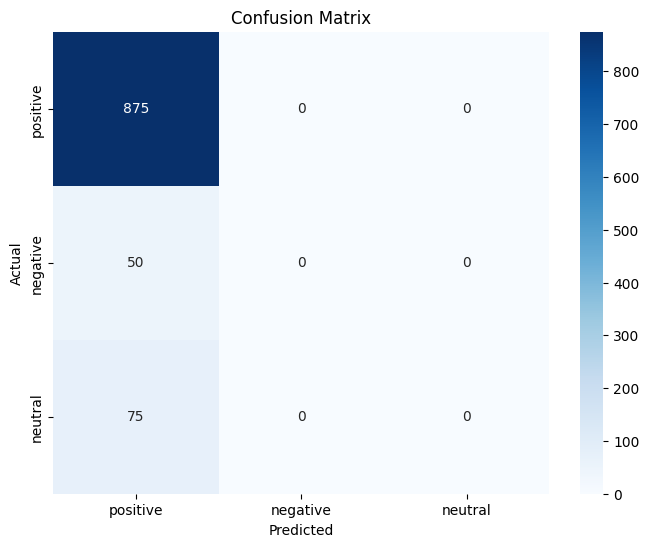

In [21]:
import seaborn as sns
test_df = test 
# (Tùy chọn) In báo cáo chi tiết
print("\nBáo cáo phân loại:")
print(classification_report(test_df['sentiment'], test_df['predicted'], target_names=['positive', 'negative', 'neutral']))

print("\nMa trận nhầm lẫn:")
# Tạo confusion matrix
cm = confusion_matrix(test_df['sentiment'], test_df['predicted'], labels=['positive', 'negative', 'neutral'])

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['positive', 'negative', 'neutral'], 
            yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Fine-tuning with Lora

In [22]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
) 
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
) 

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [23]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Chia dữ liệu theo tỷ lệ nhãn (stratified sampling)
# Lấy 1000 mẫu, đảm bảo tỷ lệ nhãn được giữ nguyên
train_df, _ = train_test_split(
    df,
    train_size=1000,  # Lấy 1000 dòng
    stratify=df['sentiment'],  # Phân tầng theo cột 'sentiment'
    random_state=42
)

# Kiểm tra phân phối nhãn để xác nhận
print("Phân phối nhãn trong tập train:")
print(train_df['sentiment'].value_counts(normalize=True))

# Chuyển đổi thành định dạng Dataset (tùy chọn, nếu sử dụng thư viện datasets)
train = Dataset.from_pandas(train_df)

# (Tùy chọn) Định dạng lại dữ liệu nếu mô hình yêu cầu
def format_data(example):
    return {
        "text": f"<start_of_turn>user\nYou are an AI expert in sentiment analysis. Given the following response, determine the overall sentiment of the speaker and return only one label: Positive, Negative, or Neutral.\n\nResponse: {example['reviews']}\n<start_of_turn>model\n{example['sentiment']}",
    }

# Áp dụng định dạng nếu cần
train = train.map(format_data)

# (Tùy chọn) Chuyển đổi thành định dạng phù hợp với Keras
import tensorflow as tf

def to_tf_dataset(dataset):
    def gen():
        for ex in dataset:
            yield (ex['text'], ex['sentiment'])
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    ).batch(1)  # Batch size = 1 như trong code gốc

train = to_tf_dataset(train)

Phân phối nhãn trong tập train:
sentiment
positive    0.879
neutral     0.075
negative    0.046
Name: proportion, dtype: float64


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

   1000/Unknown 38499s 38s/step - loss: 1.3983 - sparse_categorical_accuracy: 0.4668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


TOTAL TIME ELAPSED: 34.14s
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38534s 38s/step - loss: 1.3982 - sparse_categorical_accuracy: 0.4669


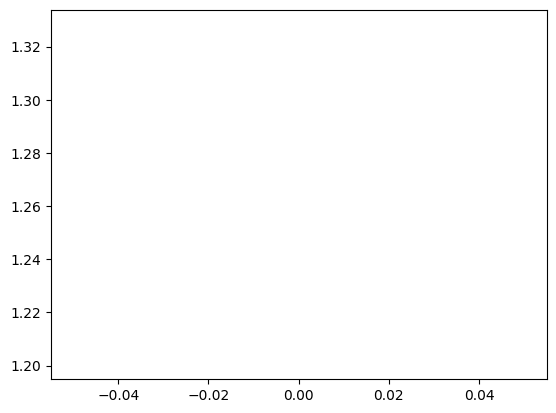

In [24]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/kaggle/working/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("I do not like this. However, it is not bad")

history = gemma_lm.fit(train, epochs=train_epoch, callbacks=[CustomCallback()])

plt.plot(history.history['loss'])
plt.show()

In [25]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Tạo tập huấn luyện và kiểm tra
train_df = df.sample(n=1000, random_state=42)
test_df = df.drop(train_df.index).sample(n=200, random_state=43)
test_df['sentiment'] = test_df['sentiment'].str.lower()

# Dự đoán nhãn cho tập kiểm tra
test_df['predicted'] = [text_gen(text) for text in tqdm(test_df['reviews'])]

# Tính độ chính xác
accuracy = (test_df['sentiment'] == test_df['predicted']).mean()
print(f"Độ chính xác trên tập kiểm tra: {accuracy:.2%}")

# (Tùy chọn) In báo cáo chi tiết
print("\nBáo cáo phân loại:")
print(classification_report(test_df['sentiment'], test_df['predicted'], target_names=['positive', 'negative', 'neutral']))

print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(test_df['sentiment'], test_df['predicted'], labels=['positive', 'negative', 'neutral'])
print(cm)

  0%|          | 1/200 [00:02<09:03,  2.73s/it]

TOTAL TIME ELAPSED: 2.73s


  1%|          | 2/200 [00:05<09:05,  2.75s/it]

TOTAL TIME ELAPSED: 2.77s


  2%|▏         | 3/200 [00:08<08:46,  2.67s/it]

TOTAL TIME ELAPSED: 2.57s


  2%|▏         | 4/200 [00:10<08:35,  2.63s/it]

TOTAL TIME ELAPSED: 2.56s


  2%|▎         | 5/200 [00:13<08:23,  2.58s/it]

TOTAL TIME ELAPSED: 2.49s


  3%|▎         | 6/200 [00:15<08:15,  2.55s/it]

TOTAL TIME ELAPSED: 2.50s


  4%|▎         | 7/200 [00:18<08:08,  2.53s/it]

TOTAL TIME ELAPSED: 2.48s


  4%|▍         | 8/200 [00:20<08:08,  2.54s/it]

TOTAL TIME ELAPSED: 2.57s


  4%|▍         | 9/200 [00:23<08:01,  2.52s/it]

TOTAL TIME ELAPSED: 2.47s


  5%|▌         | 10/200 [00:25<07:55,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


  6%|▌         | 11/200 [00:28<07:52,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


  6%|▌         | 12/200 [00:30<07:49,  2.50s/it]

TOTAL TIME ELAPSED: 2.49s


  6%|▋         | 13/200 [00:33<07:49,  2.51s/it]

TOTAL TIME ELAPSED: 2.54s


  7%|▋         | 14/200 [00:36<08:09,  2.63s/it]

TOTAL TIME ELAPSED: 2.91s


  8%|▊         | 15/200 [00:38<08:08,  2.64s/it]

TOTAL TIME ELAPSED: 2.65s


  8%|▊         | 16/200 [00:41<07:57,  2.60s/it]

TOTAL TIME ELAPSED: 2.50s


  8%|▊         | 17/200 [00:43<07:49,  2.56s/it]

TOTAL TIME ELAPSED: 2.49s


  9%|▉         | 18/200 [00:46<07:40,  2.53s/it]

TOTAL TIME ELAPSED: 2.46s


 10%|▉         | 19/200 [00:48<07:36,  2.52s/it]

TOTAL TIME ELAPSED: 2.50s


 10%|█         | 20/200 [00:51<07:37,  2.54s/it]

TOTAL TIME ELAPSED: 2.59s


 10%|█         | 21/200 [00:53<07:31,  2.52s/it]

TOTAL TIME ELAPSED: 2.47s


 11%|█         | 22/200 [00:56<07:27,  2.51s/it]

TOTAL TIME ELAPSED: 2.49s


 12%|█▏        | 23/200 [00:58<07:27,  2.53s/it]

TOTAL TIME ELAPSED: 2.56s


 12%|█▏        | 24/200 [01:01<07:22,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 12%|█▎        | 25/200 [01:03<07:22,  2.53s/it]

TOTAL TIME ELAPSED: 2.57s


 13%|█▎        | 26/200 [01:06<07:16,  2.51s/it]

TOTAL TIME ELAPSED: 2.47s


 14%|█▎        | 27/200 [01:09<07:44,  2.68s/it]

TOTAL TIME ELAPSED: 3.08s


 14%|█▍        | 28/200 [01:11<07:31,  2.63s/it]

TOTAL TIME ELAPSED: 2.49s


 14%|█▍        | 29/200 [01:14<07:23,  2.59s/it]

TOTAL TIME ELAPSED: 2.51s


 15%|█▌        | 30/200 [01:16<07:15,  2.56s/it]

TOTAL TIME ELAPSED: 2.50s


 16%|█▌        | 31/200 [01:19<07:10,  2.55s/it]

TOTAL TIME ELAPSED: 2.51s


 16%|█▌        | 32/200 [01:21<07:06,  2.54s/it]

TOTAL TIME ELAPSED: 2.52s


 16%|█▋        | 33/200 [01:24<07:02,  2.53s/it]

TOTAL TIME ELAPSED: 2.51s


 17%|█▋        | 34/200 [01:26<07:00,  2.53s/it]

TOTAL TIME ELAPSED: 2.54s


 18%|█▊        | 35/200 [01:29<06:58,  2.54s/it]

TOTAL TIME ELAPSED: 2.54s


 18%|█▊        | 36/200 [01:31<06:52,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 18%|█▊        | 37/200 [01:34<06:48,  2.51s/it]

TOTAL TIME ELAPSED: 2.50s


 19%|█▉        | 38/200 [01:36<06:43,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 20%|█▉        | 39/200 [01:39<06:42,  2.50s/it]

TOTAL TIME ELAPSED: 2.52s


 20%|██        | 40/200 [01:42<07:03,  2.65s/it]

TOTAL TIME ELAPSED: 2.98s


 20%|██        | 41/200 [01:44<06:52,  2.59s/it]

TOTAL TIME ELAPSED: 2.47s


 21%|██        | 42/200 [01:47<06:43,  2.55s/it]

TOTAL TIME ELAPSED: 2.46s


 22%|██▏       | 43/200 [01:49<06:39,  2.54s/it]

TOTAL TIME ELAPSED: 2.53s


 22%|██▏       | 44/200 [01:52<06:34,  2.53s/it]

TOTAL TIME ELAPSED: 2.50s


 22%|██▎       | 45/200 [01:54<06:28,  2.50s/it]

TOTAL TIME ELAPSED: 2.44s


 23%|██▎       | 46/200 [01:57<06:25,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 24%|██▎       | 47/200 [01:59<06:24,  2.51s/it]

TOTAL TIME ELAPSED: 2.53s


 24%|██▍       | 48/200 [02:02<06:20,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 24%|██▍       | 49/200 [02:04<06:17,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 25%|██▌       | 50/200 [02:07<06:13,  2.49s/it]

TOTAL TIME ELAPSED: 2.47s


 26%|██▌       | 51/200 [02:09<06:14,  2.51s/it]

TOTAL TIME ELAPSED: 2.55s


 26%|██▌       | 52/200 [02:12<06:17,  2.55s/it]

TOTAL TIME ELAPSED: 2.64s


 26%|██▋       | 53/200 [02:15<06:30,  2.65s/it]

TOTAL TIME ELAPSED: 2.90s


 27%|██▋       | 54/200 [02:18<06:29,  2.67s/it]

TOTAL TIME ELAPSED: 2.69s


 28%|██▊       | 55/200 [02:20<06:25,  2.66s/it]

TOTAL TIME ELAPSED: 2.65s


 28%|██▊       | 56/200 [02:23<06:19,  2.63s/it]

TOTAL TIME ELAPSED: 2.56s


 28%|██▊       | 57/200 [02:25<06:10,  2.59s/it]

TOTAL TIME ELAPSED: 2.50s


 29%|██▉       | 58/200 [02:28<06:10,  2.61s/it]

TOTAL TIME ELAPSED: 2.65s


 30%|██▉       | 59/200 [02:31<06:06,  2.60s/it]

TOTAL TIME ELAPSED: 2.58s


 30%|███       | 60/200 [02:33<05:58,  2.56s/it]

TOTAL TIME ELAPSED: 2.47s


 30%|███       | 61/200 [02:36<05:55,  2.56s/it]

TOTAL TIME ELAPSED: 2.54s


 31%|███       | 62/200 [02:38<05:49,  2.53s/it]

TOTAL TIME ELAPSED: 2.47s


 32%|███▏      | 63/200 [02:41<05:46,  2.53s/it]

TOTAL TIME ELAPSED: 2.51s


 32%|███▏      | 64/200 [02:43<05:42,  2.52s/it]

TOTAL TIME ELAPSED: 2.50s


 32%|███▎      | 65/200 [02:46<05:56,  2.64s/it]

TOTAL TIME ELAPSED: 2.92s


 33%|███▎      | 66/200 [02:49<05:52,  2.63s/it]

TOTAL TIME ELAPSED: 2.61s


 34%|███▎      | 67/200 [02:51<05:45,  2.60s/it]

TOTAL TIME ELAPSED: 2.53s


 34%|███▍      | 68/200 [02:54<05:36,  2.55s/it]

TOTAL TIME ELAPSED: 2.44s


 34%|███▍      | 69/200 [02:56<05:29,  2.52s/it]

TOTAL TIME ELAPSED: 2.44s


 35%|███▌      | 70/200 [02:58<05:27,  2.52s/it]

TOTAL TIME ELAPSED: 2.51s


 36%|███▌      | 71/200 [03:01<05:22,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 36%|███▌      | 72/200 [03:03<05:17,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 36%|███▋      | 73/200 [03:06<05:16,  2.49s/it]

TOTAL TIME ELAPSED: 2.50s


 37%|███▋      | 74/200 [03:08<05:15,  2.50s/it]

TOTAL TIME ELAPSED: 2.53s


 38%|███▊      | 75/200 [03:11<05:10,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 38%|███▊      | 76/200 [03:13<05:07,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 38%|███▊      | 77/200 [03:16<05:03,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


 39%|███▉      | 78/200 [03:19<05:22,  2.64s/it]

TOTAL TIME ELAPSED: 3.05s


 40%|███▉      | 79/200 [03:21<05:15,  2.61s/it]

TOTAL TIME ELAPSED: 2.52s


 40%|████      | 80/200 [03:24<05:08,  2.57s/it]

TOTAL TIME ELAPSED: 2.47s


 40%|████      | 81/200 [03:26<05:03,  2.55s/it]

TOTAL TIME ELAPSED: 2.50s


 41%|████      | 82/200 [03:29<04:59,  2.54s/it]

TOTAL TIME ELAPSED: 2.52s


 42%|████▏     | 83/200 [03:31<04:53,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 42%|████▏     | 84/200 [03:34<04:49,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


 42%|████▎     | 85/200 [03:36<04:48,  2.51s/it]

TOTAL TIME ELAPSED: 2.54s


 43%|████▎     | 86/200 [03:39<04:45,  2.51s/it]

TOTAL TIME ELAPSED: 2.50s


 44%|████▎     | 87/200 [03:41<04:40,  2.49s/it]

TOTAL TIME ELAPSED: 2.44s


 44%|████▍     | 88/200 [03:44<04:38,  2.48s/it]

TOTAL TIME ELAPSED: 2.48s


 44%|████▍     | 89/200 [03:46<04:35,  2.48s/it]

TOTAL TIME ELAPSED: 2.48s


 45%|████▌     | 90/200 [03:52<06:19,  3.45s/it]

TOTAL TIME ELAPSED: 5.71s


 46%|████▌     | 91/200 [03:55<06:08,  3.38s/it]

TOTAL TIME ELAPSED: 3.21s


 46%|████▌     | 92/200 [03:58<05:37,  3.12s/it]

TOTAL TIME ELAPSED: 2.51s


 46%|████▋     | 93/200 [04:00<05:16,  2.96s/it]

TOTAL TIME ELAPSED: 2.57s


 47%|████▋     | 94/200 [04:03<04:58,  2.81s/it]

TOTAL TIME ELAPSED: 2.47s


 48%|████▊     | 95/200 [04:05<04:44,  2.71s/it]

TOTAL TIME ELAPSED: 2.48s


 48%|████▊     | 96/200 [04:08<04:36,  2.66s/it]

TOTAL TIME ELAPSED: 2.52s


 48%|████▊     | 97/200 [04:10<04:29,  2.62s/it]

TOTAL TIME ELAPSED: 2.53s


 49%|████▉     | 98/200 [04:13<04:22,  2.58s/it]

TOTAL TIME ELAPSED: 2.48s


 50%|████▉     | 99/200 [04:15<04:16,  2.54s/it]

TOTAL TIME ELAPSED: 2.46s


 50%|█████     | 100/200 [04:18<04:12,  2.53s/it]

TOTAL TIME ELAPSED: 2.49s


 50%|█████     | 101/200 [04:20<04:10,  2.53s/it]

TOTAL TIME ELAPSED: 2.54s


 51%|█████     | 102/200 [04:23<04:05,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 52%|█████▏    | 103/200 [04:26<04:16,  2.64s/it]

TOTAL TIME ELAPSED: 2.94s


 52%|█████▏    | 104/200 [04:28<04:10,  2.61s/it]

TOTAL TIME ELAPSED: 2.53s


 52%|█████▎    | 105/200 [04:31<04:04,  2.58s/it]

TOTAL TIME ELAPSED: 2.51s


 53%|█████▎    | 106/200 [04:33<03:59,  2.55s/it]

TOTAL TIME ELAPSED: 2.47s


 54%|█████▎    | 107/200 [04:36<03:54,  2.52s/it]

TOTAL TIME ELAPSED: 2.45s


 54%|█████▍    | 108/200 [04:38<03:52,  2.53s/it]

TOTAL TIME ELAPSED: 2.56s


 55%|█████▍    | 109/200 [04:41<03:49,  2.52s/it]

TOTAL TIME ELAPSED: 2.49s


 55%|█████▌    | 110/200 [04:43<03:45,  2.50s/it]

TOTAL TIME ELAPSED: 2.46s


 56%|█████▌    | 111/200 [04:46<03:41,  2.49s/it]

TOTAL TIME ELAPSED: 2.45s


 56%|█████▌    | 112/200 [04:48<03:37,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


 56%|█████▋    | 113/200 [04:50<03:36,  2.48s/it]

TOTAL TIME ELAPSED: 2.51s


 57%|█████▋    | 114/200 [04:53<03:32,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


 57%|█████▊    | 115/200 [04:55<03:29,  2.46s/it]

TOTAL TIME ELAPSED: 2.44s


 58%|█████▊    | 116/200 [04:59<03:44,  2.68s/it]

TOTAL TIME ELAPSED: 3.18s


 58%|█████▊    | 117/200 [05:01<03:36,  2.61s/it]

TOTAL TIME ELAPSED: 2.46s


 59%|█████▉    | 118/200 [05:03<03:30,  2.57s/it]

TOTAL TIME ELAPSED: 2.47s


 60%|█████▉    | 119/200 [05:06<03:25,  2.54s/it]

TOTAL TIME ELAPSED: 2.47s


 60%|██████    | 120/200 [05:09<03:24,  2.56s/it]

TOTAL TIME ELAPSED: 2.60s


 60%|██████    | 121/200 [05:11<03:19,  2.52s/it]

TOTAL TIME ELAPSED: 2.44s


 61%|██████    | 122/200 [05:13<03:15,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 62%|██████▏   | 123/200 [05:16<03:12,  2.49s/it]

TOTAL TIME ELAPSED: 2.48s


 62%|██████▏   | 124/200 [05:18<03:10,  2.50s/it]

TOTAL TIME ELAPSED: 2.51s


 62%|██████▎   | 125/200 [05:21<03:09,  2.52s/it]

TOTAL TIME ELAPSED: 2.58s


 63%|██████▎   | 126/200 [05:23<03:05,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 64%|██████▎   | 127/200 [05:26<03:02,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 64%|██████▍   | 128/200 [05:29<03:02,  2.53s/it]

TOTAL TIME ELAPSED: 2.61s


 64%|██████▍   | 129/200 [05:32<03:10,  2.68s/it]

TOTAL TIME ELAPSED: 3.04s


 65%|██████▌   | 130/200 [05:34<03:02,  2.61s/it]

TOTAL TIME ELAPSED: 2.46s


 66%|██████▌   | 131/200 [05:36<02:56,  2.56s/it]

TOTAL TIME ELAPSED: 2.45s


 66%|██████▌   | 132/200 [05:39<02:55,  2.57s/it]

TOTAL TIME ELAPSED: 2.60s


 66%|██████▋   | 133/200 [05:42<02:49,  2.54s/it]

TOTAL TIME ELAPSED: 2.45s


 67%|██████▋   | 134/200 [05:44<02:46,  2.52s/it]

TOTAL TIME ELAPSED: 2.47s


 68%|██████▊   | 135/200 [05:46<02:42,  2.50s/it]

TOTAL TIME ELAPSED: 2.45s


 68%|██████▊   | 136/200 [05:49<02:39,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 68%|██████▊   | 137/200 [05:51<02:36,  2.48s/it]

TOTAL TIME ELAPSED: 2.44s


 69%|██████▉   | 138/200 [05:54<02:33,  2.47s/it]

TOTAL TIME ELAPSED: 2.44s


 70%|██████▉   | 139/200 [05:56<02:30,  2.47s/it]

TOTAL TIME ELAPSED: 2.46s


 70%|███████   | 140/200 [05:59<02:28,  2.48s/it]

TOTAL TIME ELAPSED: 2.50s


 70%|███████   | 141/200 [06:01<02:25,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


 71%|███████   | 142/200 [06:04<02:32,  2.63s/it]

TOTAL TIME ELAPSED: 2.99s


 72%|███████▏  | 143/200 [06:07<02:26,  2.57s/it]

TOTAL TIME ELAPSED: 2.45s


 72%|███████▏  | 144/200 [06:09<02:22,  2.55s/it]

TOTAL TIME ELAPSED: 2.50s


 72%|███████▎  | 145/200 [06:12<02:19,  2.53s/it]

TOTAL TIME ELAPSED: 2.49s


 73%|███████▎  | 146/200 [06:14<02:16,  2.52s/it]

TOTAL TIME ELAPSED: 2.49s


 74%|███████▎  | 147/200 [06:17<02:12,  2.50s/it]

TOTAL TIME ELAPSED: 2.43s


 74%|███████▍  | 148/200 [06:19<02:10,  2.51s/it]

TOTAL TIME ELAPSED: 2.54s


 74%|███████▍  | 149/200 [06:22<02:06,  2.49s/it]

TOTAL TIME ELAPSED: 2.43s


 75%|███████▌  | 150/200 [06:24<02:03,  2.48s/it]

TOTAL TIME ELAPSED: 2.46s


 76%|███████▌  | 151/200 [06:27<02:01,  2.48s/it]

TOTAL TIME ELAPSED: 2.47s


 76%|███████▌  | 152/200 [06:29<01:59,  2.49s/it]

TOTAL TIME ELAPSED: 2.54s


 76%|███████▋  | 153/200 [06:31<01:56,  2.47s/it]

TOTAL TIME ELAPSED: 2.43s


 77%|███████▋  | 154/200 [06:34<01:53,  2.47s/it]

TOTAL TIME ELAPSED: 2.47s


 78%|███████▊  | 155/200 [06:37<01:58,  2.63s/it]

TOTAL TIME ELAPSED: 2.98s


 78%|███████▊  | 156/200 [06:39<01:54,  2.61s/it]

TOTAL TIME ELAPSED: 2.57s


 78%|███████▊  | 157/200 [06:42<01:51,  2.59s/it]

TOTAL TIME ELAPSED: 2.55s


 79%|███████▉  | 158/200 [06:45<01:48,  2.57s/it]

TOTAL TIME ELAPSED: 2.54s


 80%|███████▉  | 159/200 [06:47<01:44,  2.54s/it]

TOTAL TIME ELAPSED: 2.46s


 80%|████████  | 160/200 [06:50<01:41,  2.53s/it]

TOTAL TIME ELAPSED: 2.52s


 80%|████████  | 161/200 [06:52<01:37,  2.51s/it]

TOTAL TIME ELAPSED: 2.44s


 81%|████████  | 162/200 [06:54<01:34,  2.50s/it]

TOTAL TIME ELAPSED: 2.48s


 82%|████████▏ | 163/200 [06:57<01:32,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 82%|████████▏ | 164/200 [06:59<01:29,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 82%|████████▎ | 165/200 [07:02<01:26,  2.48s/it]

TOTAL TIME ELAPSED: 2.45s


 83%|████████▎ | 166/200 [07:04<01:24,  2.47s/it]

TOTAL TIME ELAPSED: 2.45s


 84%|████████▎ | 167/200 [07:07<01:23,  2.52s/it]

TOTAL TIME ELAPSED: 2.64s


 84%|████████▍ | 168/200 [07:10<01:24,  2.63s/it]

TOTAL TIME ELAPSED: 2.89s


 84%|████████▍ | 169/200 [07:13<01:21,  2.62s/it]

TOTAL TIME ELAPSED: 2.59s


 85%|████████▌ | 170/200 [07:15<01:17,  2.58s/it]

TOTAL TIME ELAPSED: 2.47s


 86%|████████▌ | 171/200 [07:18<01:14,  2.56s/it]

TOTAL TIME ELAPSED: 2.52s


 86%|████████▌ | 172/200 [07:20<01:11,  2.56s/it]

TOTAL TIME ELAPSED: 2.57s


 86%|████████▋ | 173/200 [07:23<01:08,  2.54s/it]

TOTAL TIME ELAPSED: 2.50s


 87%|████████▋ | 174/200 [07:25<01:05,  2.52s/it]

TOTAL TIME ELAPSED: 2.47s


 88%|████████▊ | 175/200 [07:28<01:03,  2.54s/it]

TOTAL TIME ELAPSED: 2.59s


 88%|████████▊ | 176/200 [07:30<01:00,  2.53s/it]

TOTAL TIME ELAPSED: 2.52s


 88%|████████▊ | 177/200 [07:33<00:57,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


 89%|████████▉ | 178/200 [07:35<00:55,  2.52s/it]

TOTAL TIME ELAPSED: 2.54s


 90%|████████▉ | 179/200 [07:38<00:52,  2.52s/it]

TOTAL TIME ELAPSED: 2.52s


 90%|█████████ | 180/200 [07:41<00:52,  2.63s/it]

TOTAL TIME ELAPSED: 2.87s


 90%|█████████ | 181/200 [07:43<00:50,  2.64s/it]

TOTAL TIME ELAPSED: 2.65s


 91%|█████████ | 182/200 [07:46<00:46,  2.58s/it]

TOTAL TIME ELAPSED: 2.45s


 92%|█████████▏| 183/200 [07:48<00:43,  2.54s/it]

TOTAL TIME ELAPSED: 2.45s


 92%|█████████▏| 184/200 [07:51<00:40,  2.54s/it]

TOTAL TIME ELAPSED: 2.52s


 92%|█████████▎| 185/200 [07:53<00:37,  2.51s/it]

TOTAL TIME ELAPSED: 2.45s


 93%|█████████▎| 186/200 [07:56<00:35,  2.50s/it]

TOTAL TIME ELAPSED: 2.47s


 94%|█████████▎| 187/200 [07:58<00:32,  2.49s/it]

TOTAL TIME ELAPSED: 2.46s


 94%|█████████▍| 188/200 [08:01<00:30,  2.50s/it]

TOTAL TIME ELAPSED: 2.53s


 94%|█████████▍| 189/200 [08:03<00:27,  2.50s/it]

TOTAL TIME ELAPSED: 2.51s


 95%|█████████▌| 190/200 [08:06<00:24,  2.49s/it]

TOTAL TIME ELAPSED: 2.47s


 96%|█████████▌| 191/200 [08:08<00:22,  2.49s/it]

TOTAL TIME ELAPSED: 2.49s


 96%|█████████▌| 192/200 [08:11<00:19,  2.50s/it]

TOTAL TIME ELAPSED: 2.50s


 96%|█████████▋| 193/200 [08:13<00:18,  2.63s/it]

TOTAL TIME ELAPSED: 2.94s


 97%|█████████▋| 194/200 [08:16<00:15,  2.62s/it]

TOTAL TIME ELAPSED: 2.60s


 98%|█████████▊| 195/200 [08:19<00:12,  2.60s/it]

TOTAL TIME ELAPSED: 2.53s


 98%|█████████▊| 196/200 [08:21<00:10,  2.56s/it]

TOTAL TIME ELAPSED: 2.48s


 98%|█████████▊| 197/200 [08:24<00:07,  2.53s/it]

TOTAL TIME ELAPSED: 2.46s


 99%|█████████▉| 198/200 [08:26<00:05,  2.51s/it]

TOTAL TIME ELAPSED: 2.46s


100%|█████████▉| 199/200 [08:29<00:02,  2.52s/it]

TOTAL TIME ELAPSED: 2.54s


100%|██████████| 200/200 [08:31<00:00,  2.56s/it]

TOTAL TIME ELAPSED: 2.47s
Độ chính xác trên tập kiểm tra: 91.50%

Báo cáo phân loại:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         9
    negative       0.00      0.00      0.00         8
     neutral       0.92      1.00      0.96       183

    accuracy                           0.92       200
   macro avg       0.30      0.33      0.32       200
weighted avg       0.84      0.92      0.87       200


Ma trận nhầm lẫn:
[[183   0   0]
 [  9   0   0]
 [  8   0   0]]



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


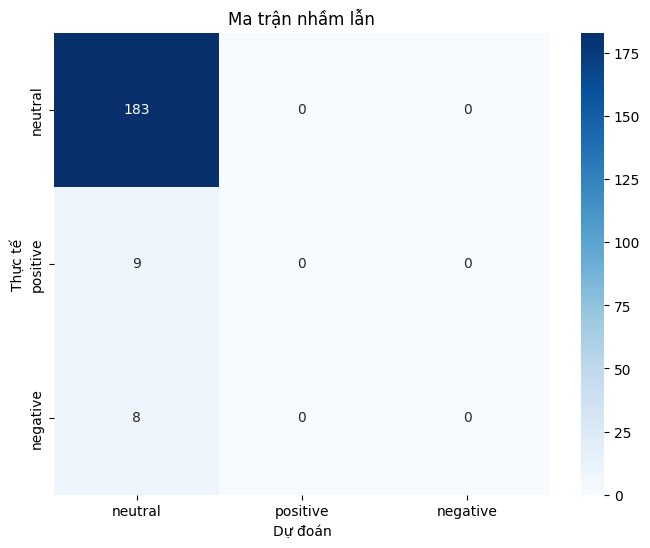

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dữ liệu báo cáo phân loại
classification_report_data = {
    '': ['positive', 'negative', 'neutral', 'accuracy', 'macro avg', 'weighted avg'],
    'precision': [0.00, 0.00, 0.92, '', 0.30, 0.84],
    'recall': [0.00, 0.00, 1.00, '', 0.33, 0.92],
    'f1-score': [0.00, 0.00, 0.96, 0.92, 0.32, 0.87],
    'support': [9, 8, 183, 200, 200, 200]
}

# Tạo DataFrame cho báo cáo phân loại
df_report = pd.DataFrame(classification_report_data)
df_report.set_index('', inplace=True)

# Dữ liệu ma trận nhầm lẫn
confusion_matrix = np.array([[183, 0, 0],
                            [9, 0, 0],
                            [8, 0, 0]])

# Nhãn cho ma trận nhầm lẫn
labels = ['neutral', 'positive', 'negative']

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()